<a href="https://colab.research.google.com/github/Vijay-K-2003/Deep_Learning_Models/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP


In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 45.7 MB/s eta 0:00:00


In [2]:
import lightning as L

import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

import os

In [3]:
random_seed = 42
torch.manual_seed(random_seed)

In [4]:
BATCH_SIZE = 128
NUM_WORKERS = int(os.cpu_count()/2)
AVAILABLE_GPUS = torch.cuda.device_count()

In [5]:
class MNISTDataModule(L.LightningDataModule):

    def __init__(self,
                 data_dir="./data",
                 batch_size=BATCH_SIZE,
                 num_workers=NUM_WORKERS) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str) -> None:
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return torch.sigmoid(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        # Latent Space to Linear Layer and Reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)
        # Upsample 16*16 : 64 feature maps
        x = F.relu(self.ct1(x))
        # Upsample 34*34 : 16 feature maps
        x = F.relu(self.ct2(x))
        # Convolution to 28*28 : 1 feature map
        return self.conv(x)

In [18]:
class GAN(L.LightningModule):
    def __init__(self,
                 latent_dim=250,
                 lr=0.0001):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # Random Noise to test the images.
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        self.g_losses = []
        self.d_losses = []

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, predicted_labels, actual_labels):
        return F.binary_cross_entropy(predicted_labels, actual_labels)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        opt_g, opt_d = self.optimizers()

        ### Discriminator Training ###
        opt_d.zero_grad()

        # Generate fake images
        fake_imgs = self(z).detach()

        # Discriminator loss for real images
        real_predicted_labels = self.discriminator(real_imgs)
        real_loss = -torch.mean(real_predicted_labels)

        # Discriminator loss for fake images
        fake_predicted_labels = self.discriminator(fake_imgs)
        fake_loss = torch.mean(fake_predicted_labels)

        # Gradient penalty
        alpha = torch.rand(real_imgs.size(0), 1, 1, 1).type_as(real_imgs)
        interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        d_interpolates = self.discriminator(interpolates)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        lambda_gp = 10  # Gradient penalty coefficient

        d_loss = real_loss + fake_loss + lambda_gp * gradient_penalty
        self.log("d_loss", d_loss, prog_bar=True)
        self.d_losses.append(d_loss.item())

        # Backward and optimize
        self.manual_backward(d_loss)
        opt_d.step()

        ### Generator Training ###
        opt_g.zero_grad()

        # Generate fake images
        fake_imgs = self(z)

        # Generator loss
        fake_predicted_labels = self.discriminator(fake_imgs)
        g_loss = -torch.mean(fake_predicted_labels)
        self.log("g_loss", g_loss, prog_bar=True)
        self.g_losses.append(g_loss.item())

        # Backward and optimize
        self.manual_backward(g_loss)
        opt_g.step()

    def configure_optimizers(self):
        lr = self.hparams.lr

        opt_g = optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr)

        return [opt_g, opt_d], []

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.g_losses, label="Generator Loss")
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title("GAN Training Losses")
        plt.legend()
        plt.show()

    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print("Epoch ", self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach().numpy()[i, 0, :, :], cmap="gray_r", interpolation=None)
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
        plt.show()

    def on_train_epoch_end(self):
        self.plot_images()
        self.plot_losses()


In [19]:
dm = MNISTDataModule()
model = GAN()

Epoch  0


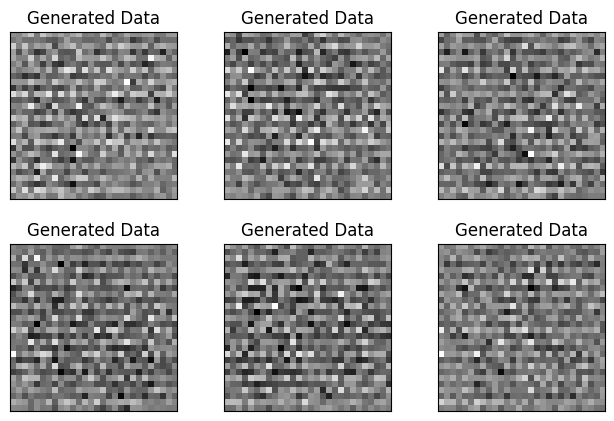

In [20]:
model.plot_images()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 828 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.401     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.

Training: |          | 0/? [00:00<?, ?it/s]

Epoch  0


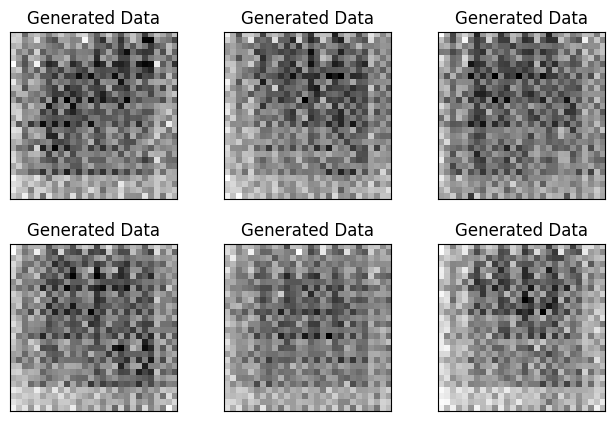

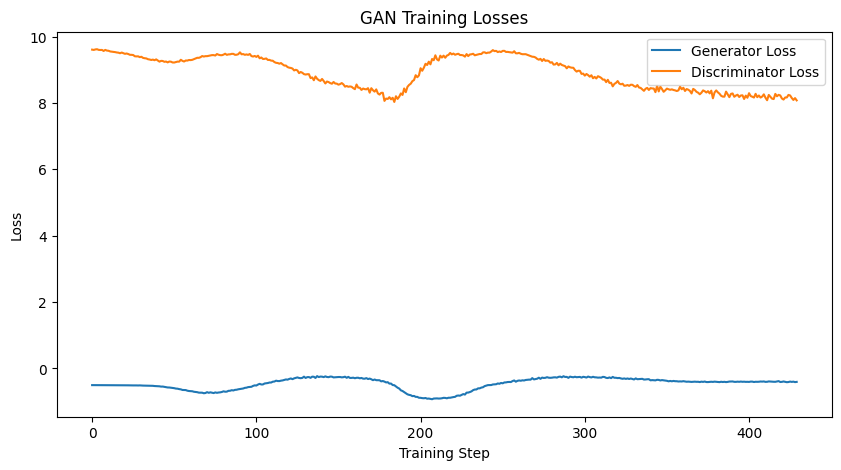

Epoch  1


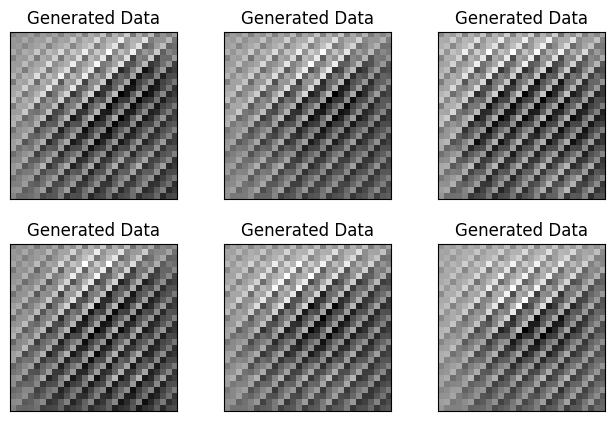

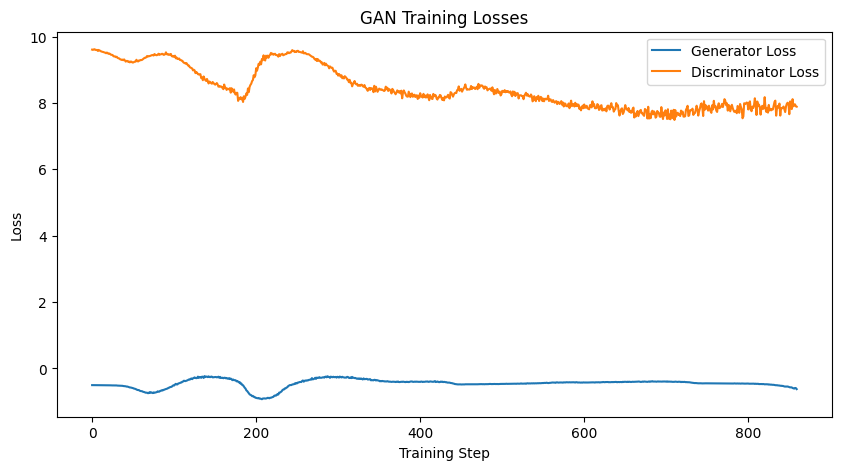

Epoch  2


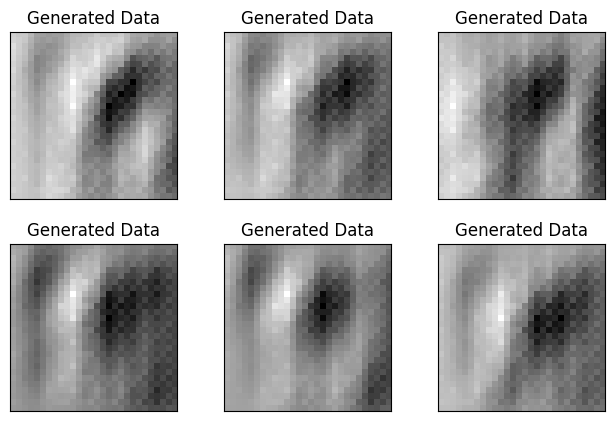

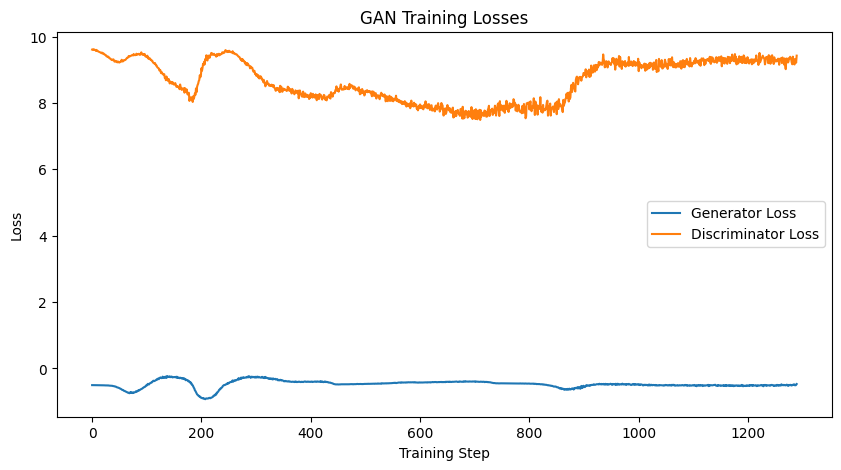

Epoch  3


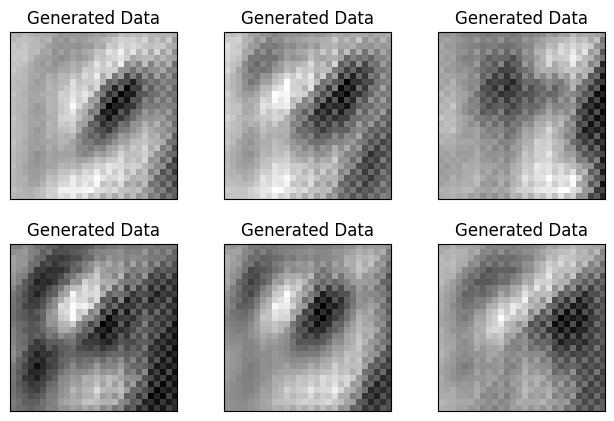

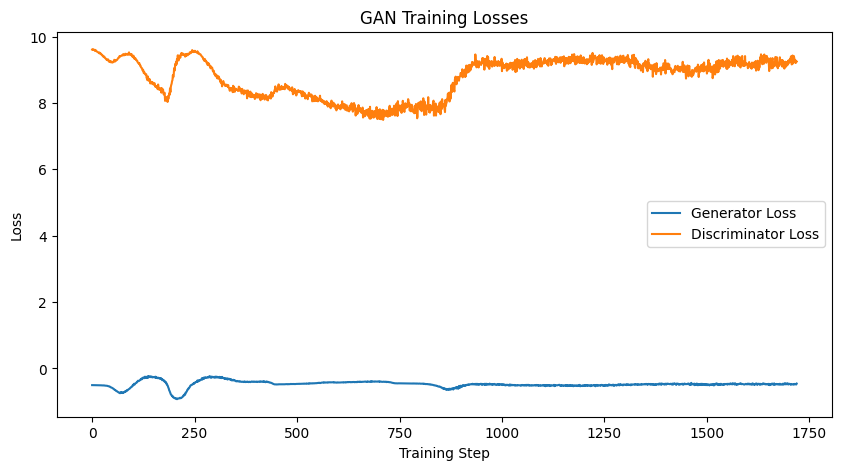

Epoch  4


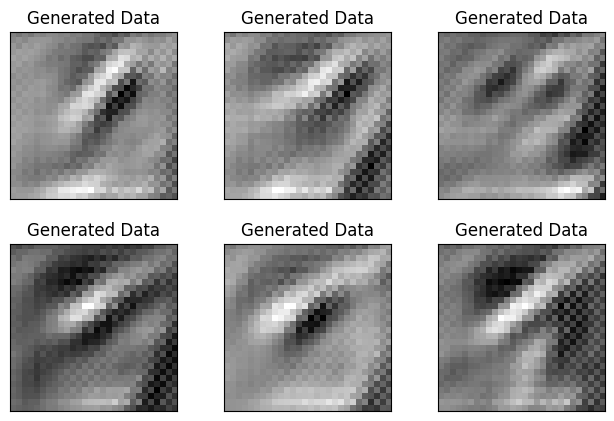

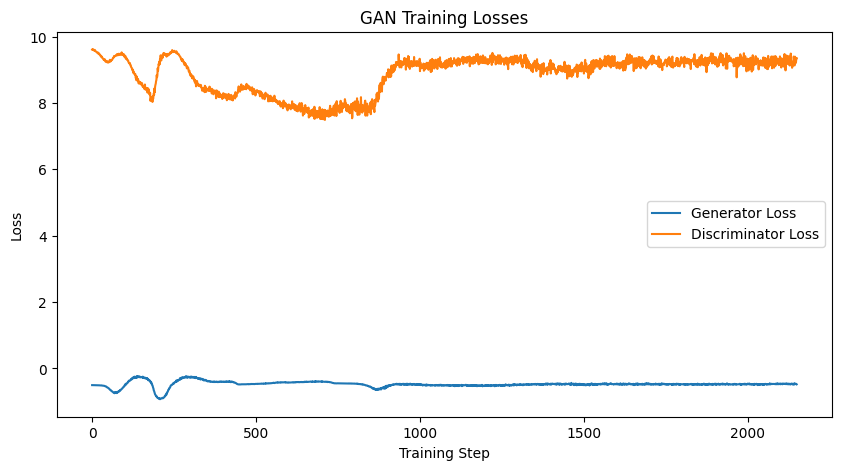

Epoch  5


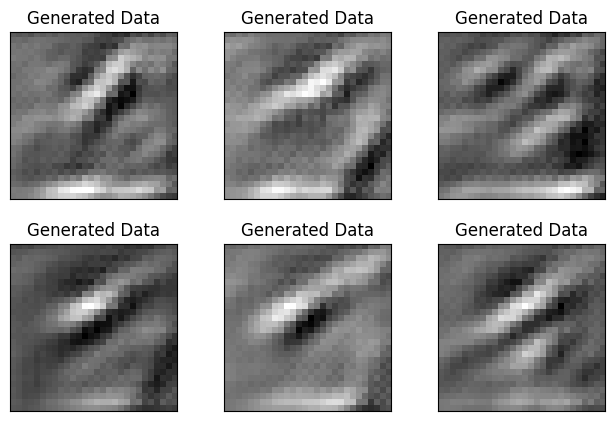

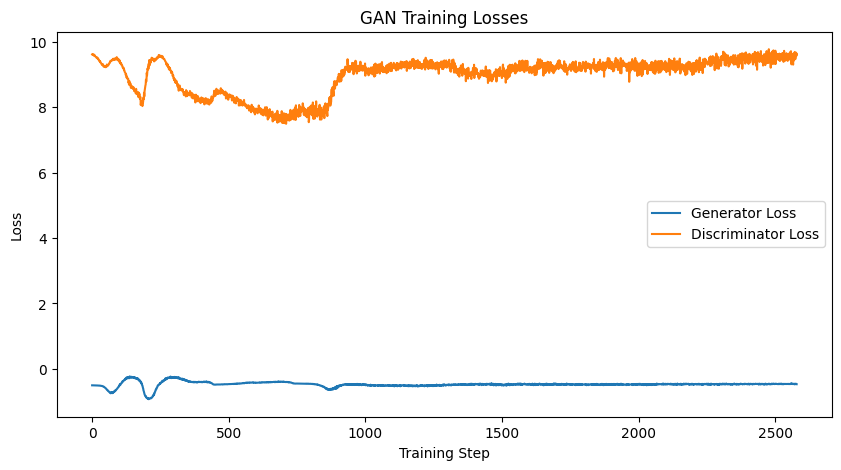

Epoch  6


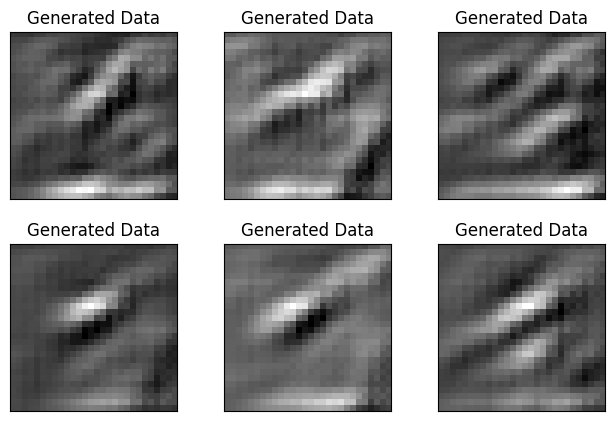

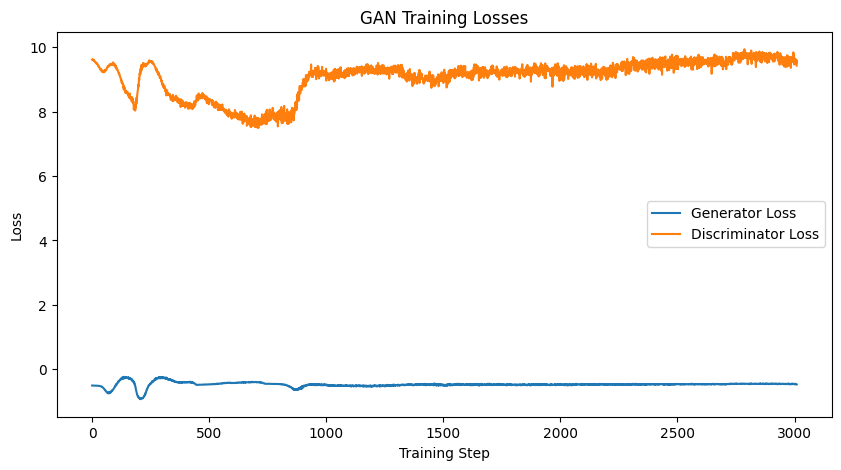

Epoch  7


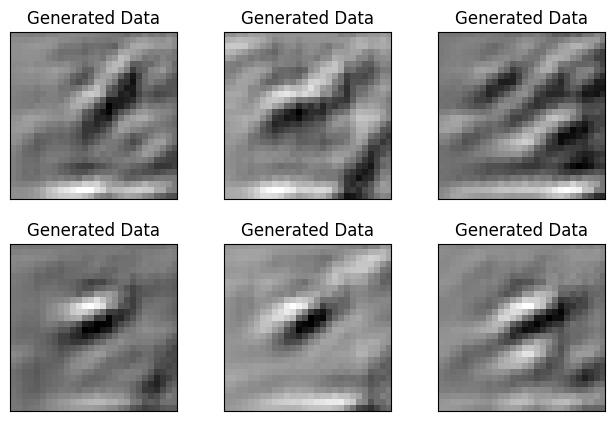

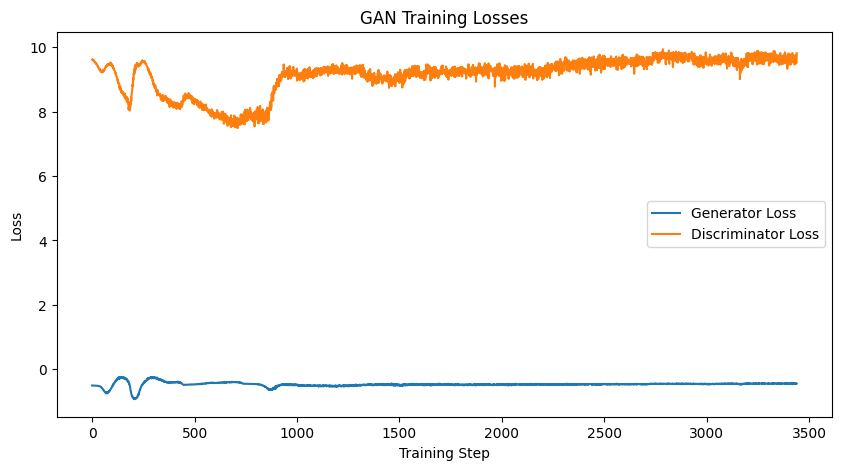

Epoch  8


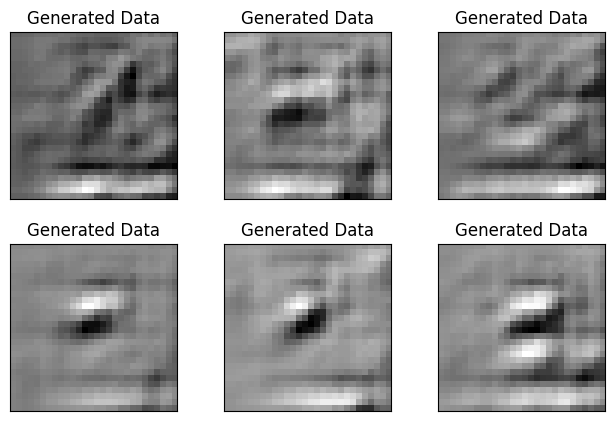

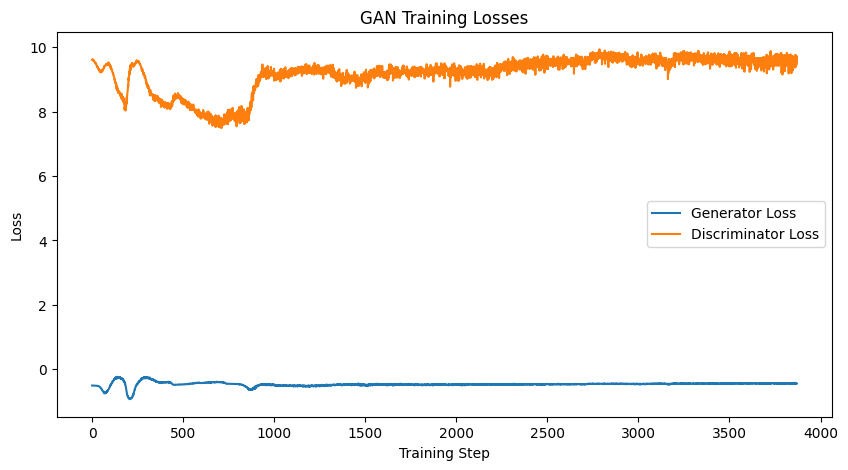

Epoch  9


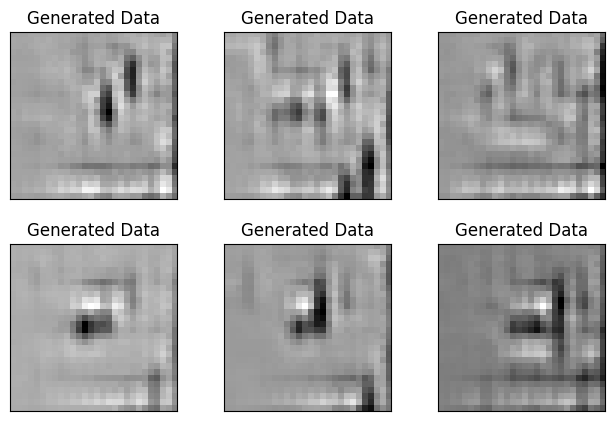

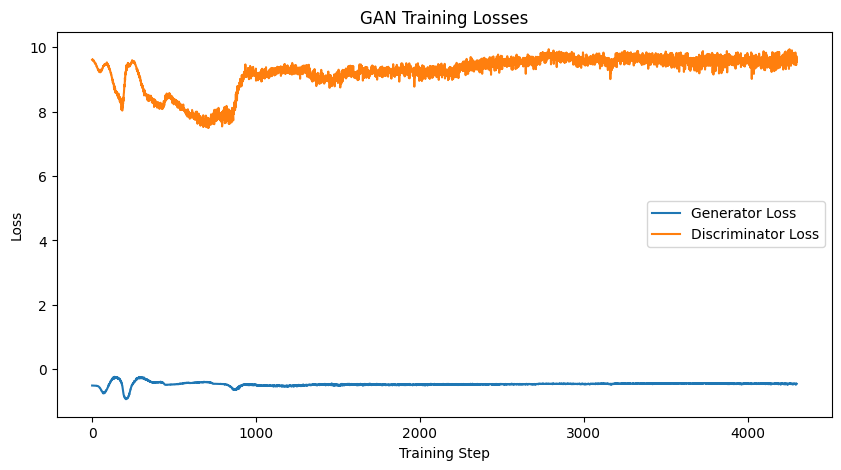

Epoch  10


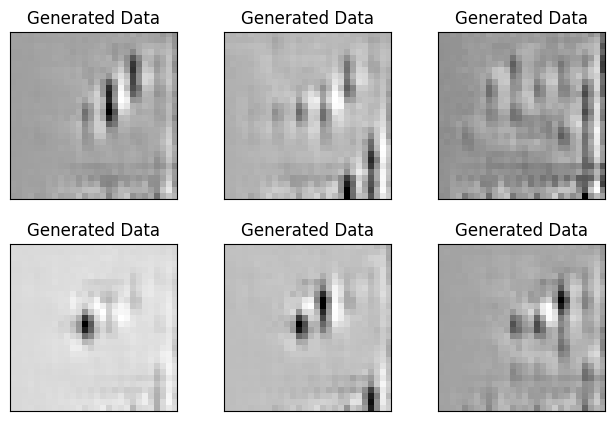

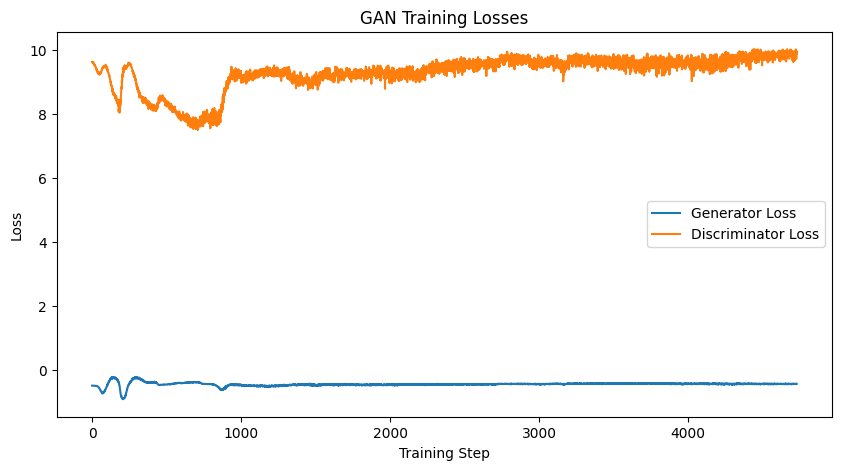

Epoch  11


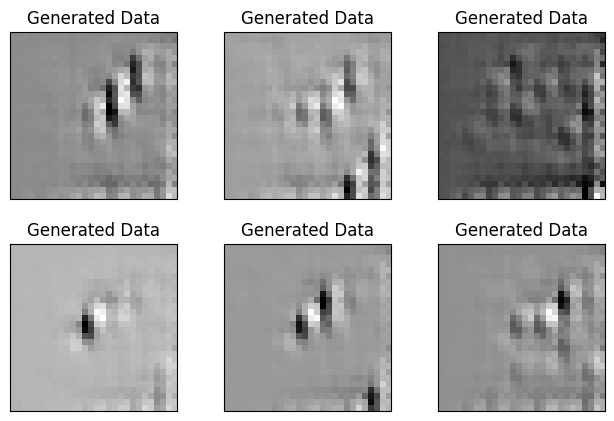

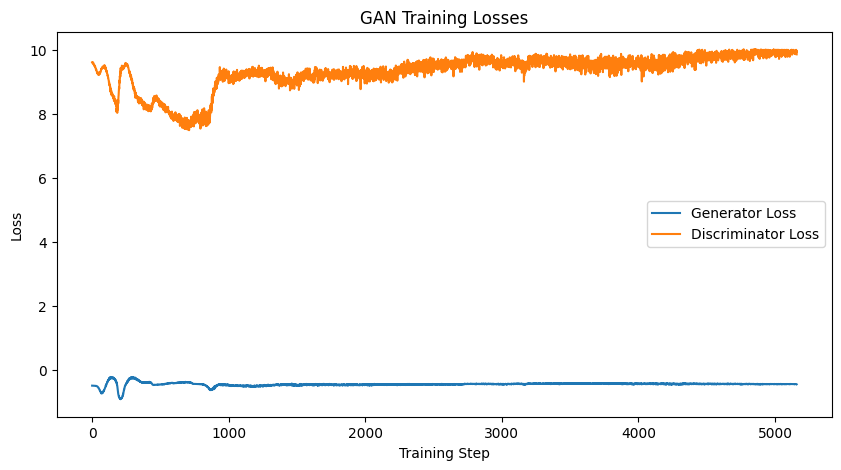

Epoch  12


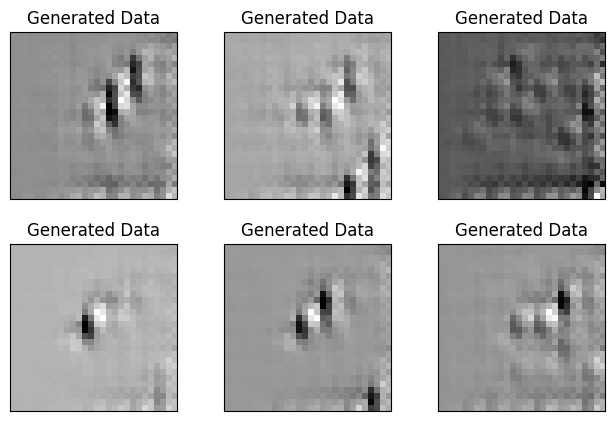

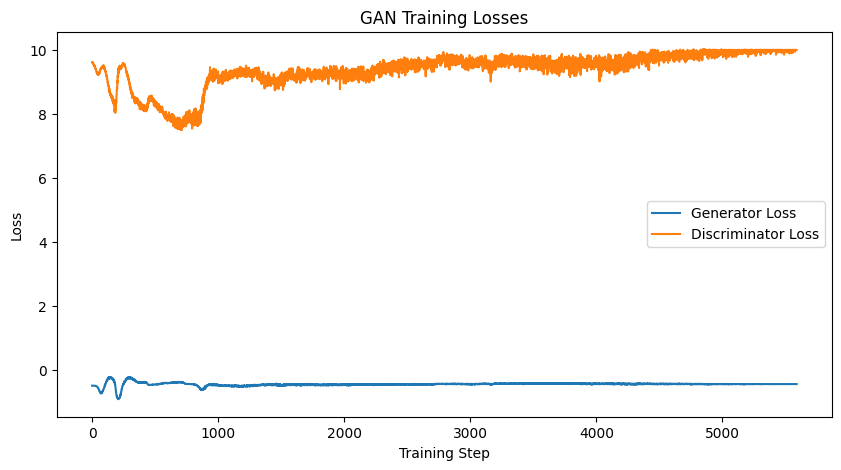

Epoch  13


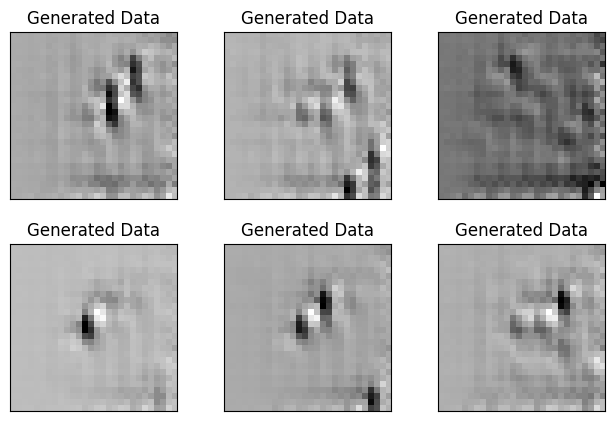

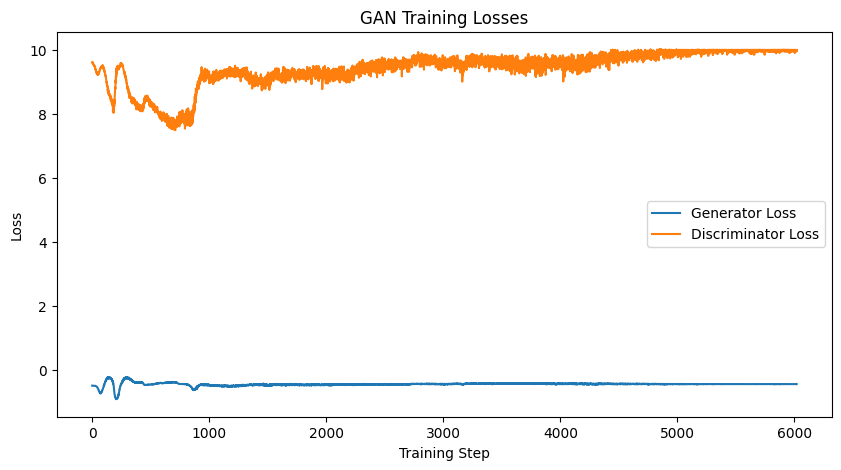

Epoch  14


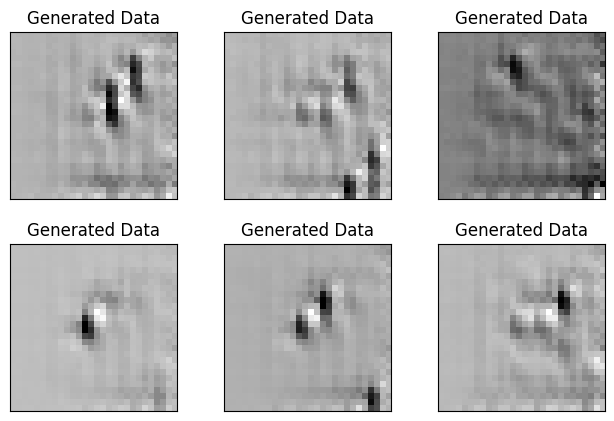

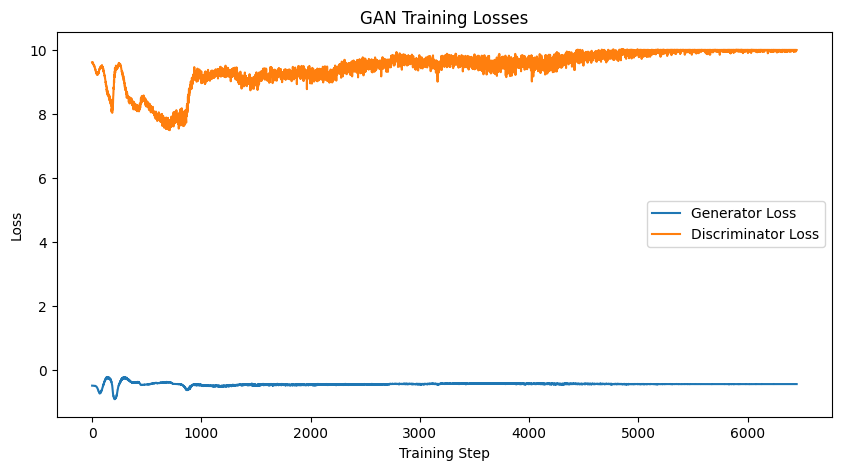

Epoch  15


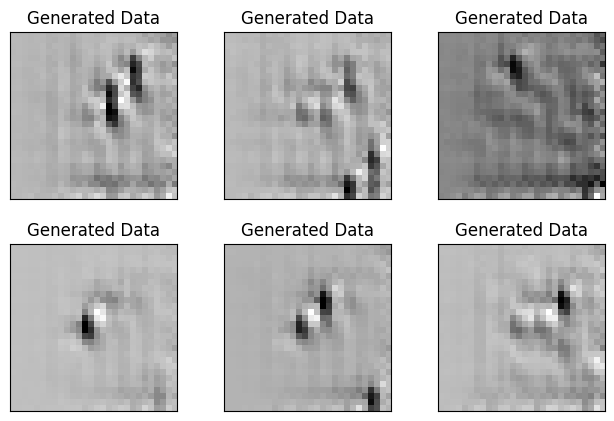

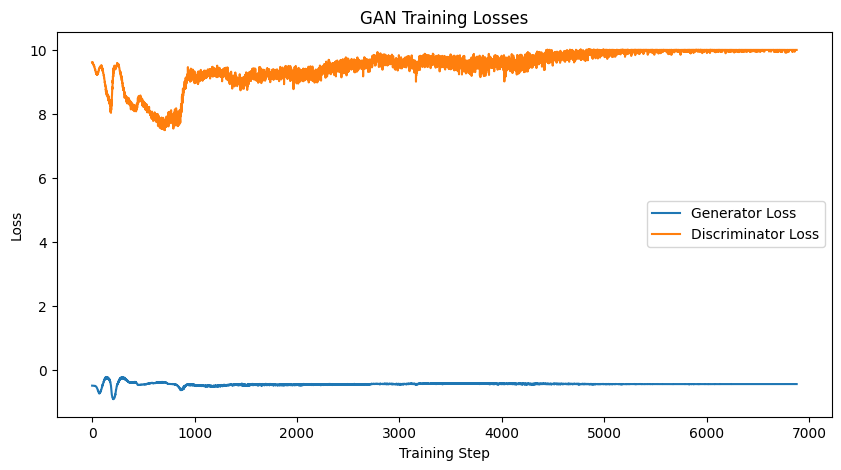

Epoch  16


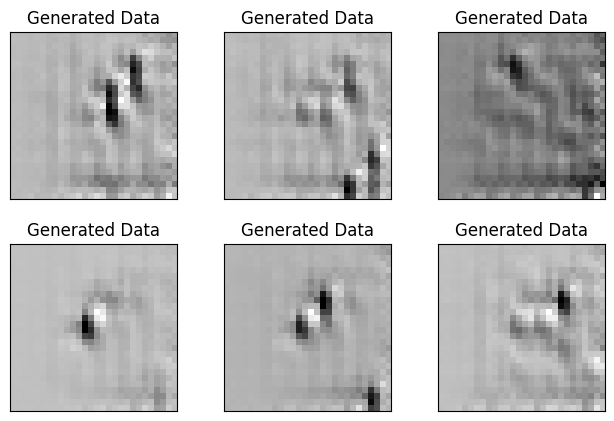

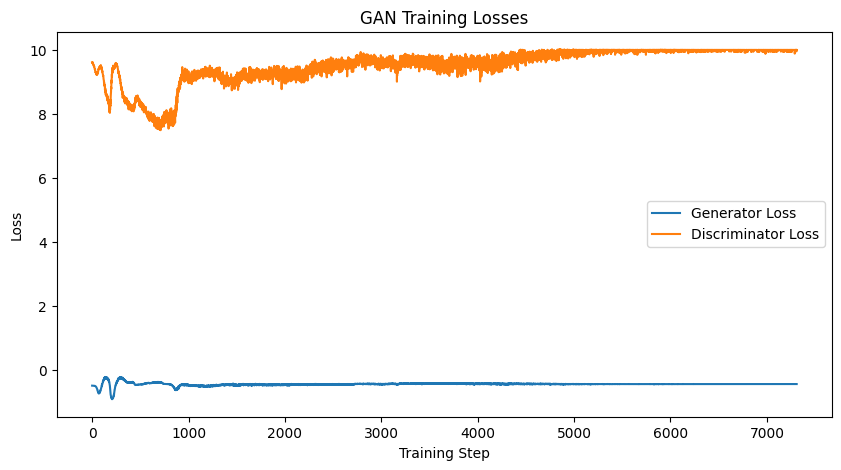

Epoch  17


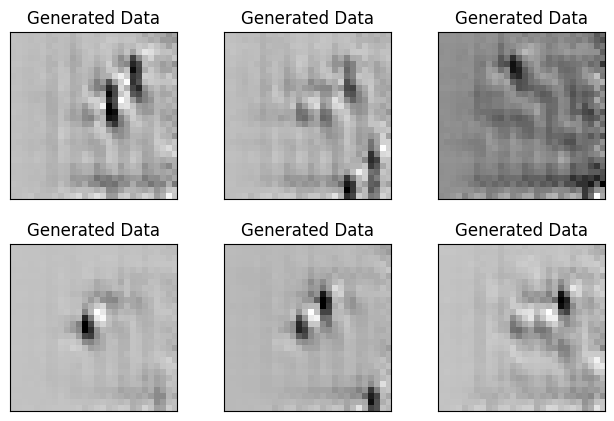

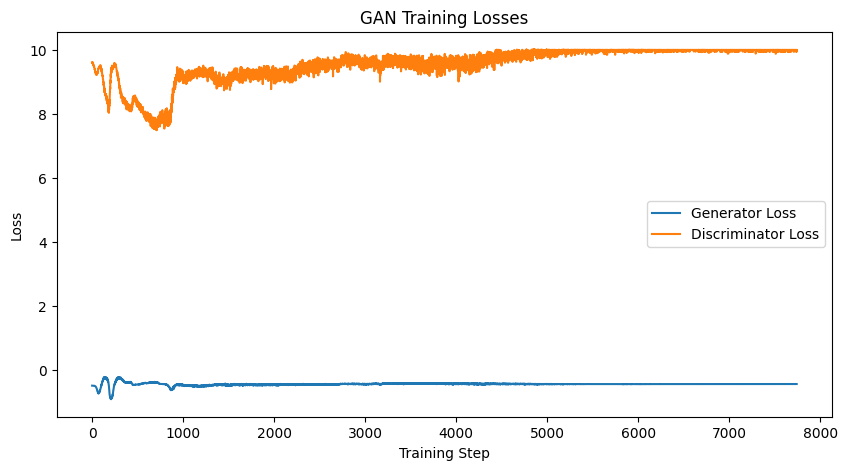

Epoch  18


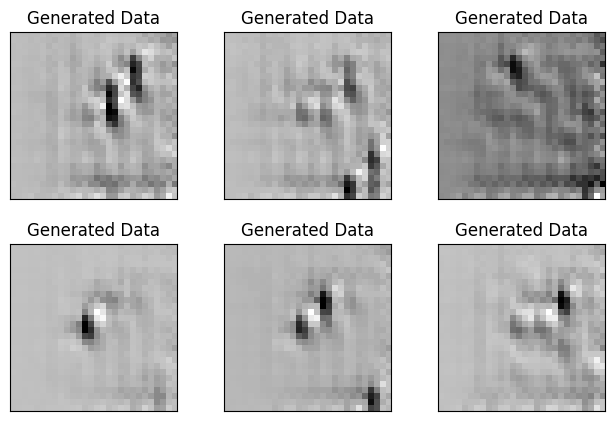

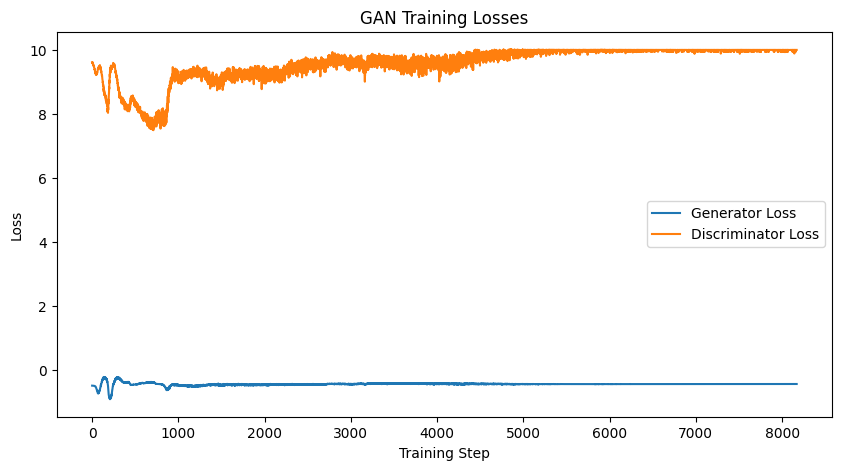

Epoch  19


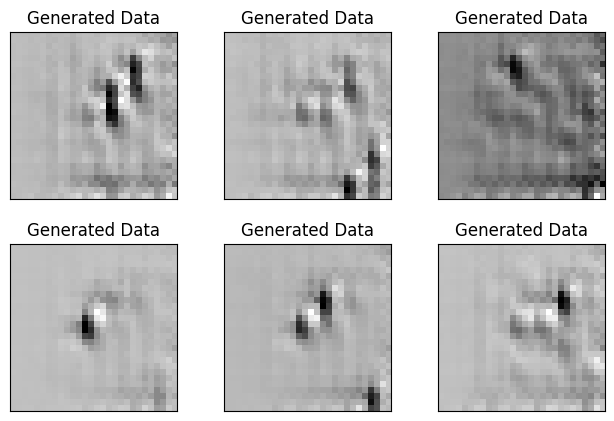

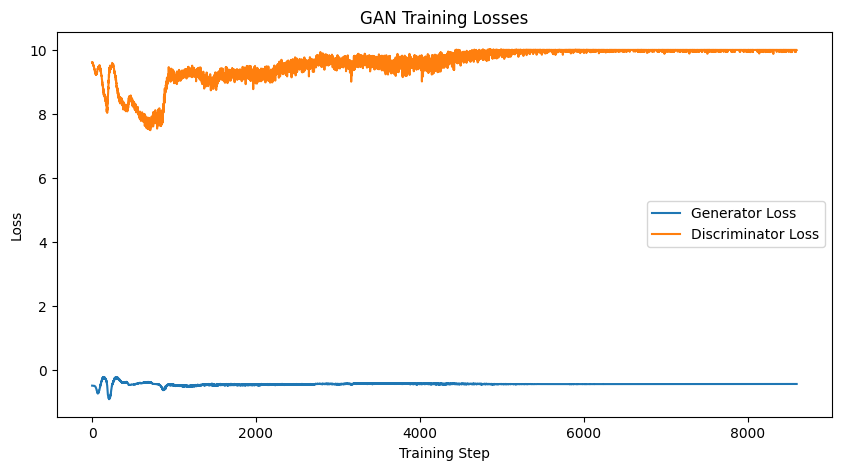

Epoch  20


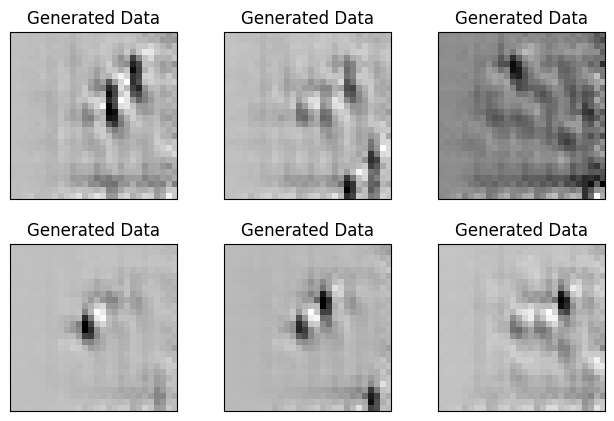

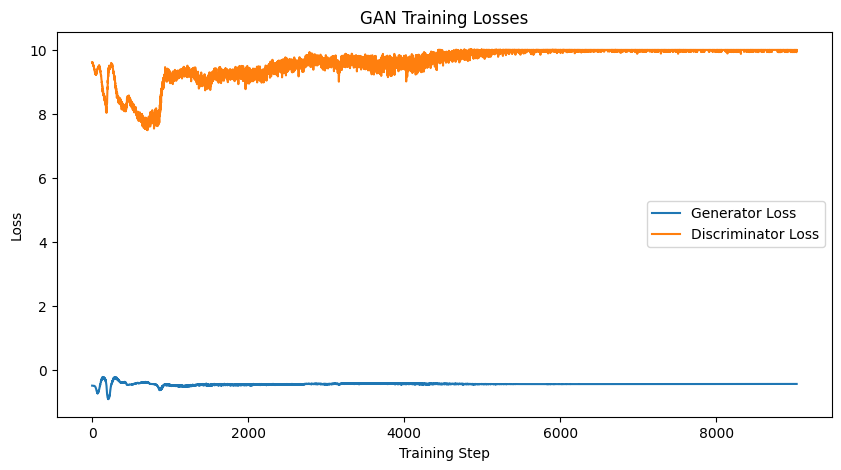

Epoch  21


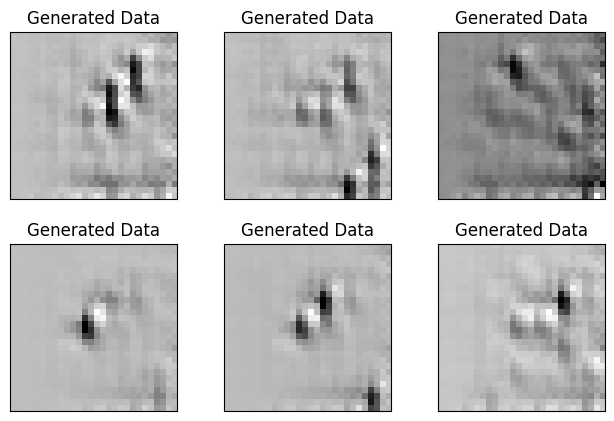

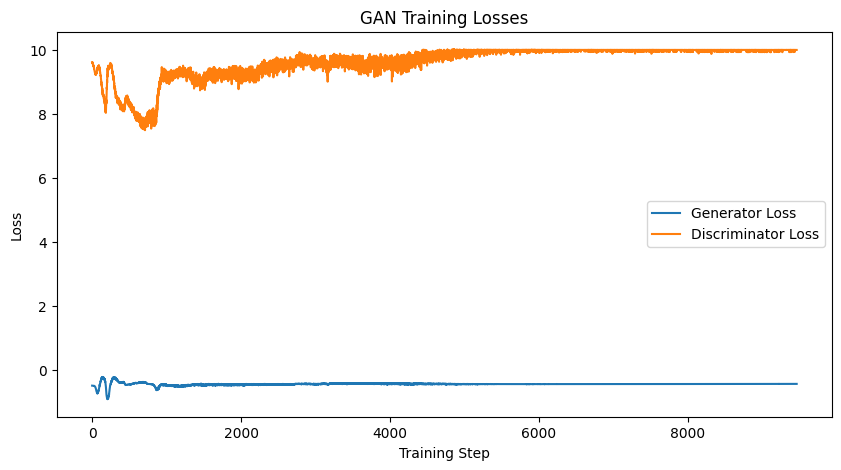

Epoch  22


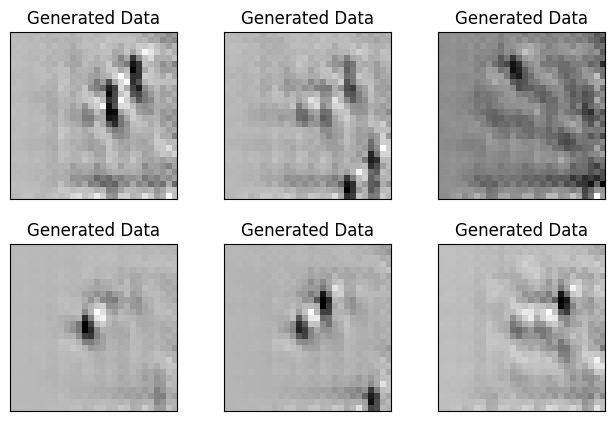

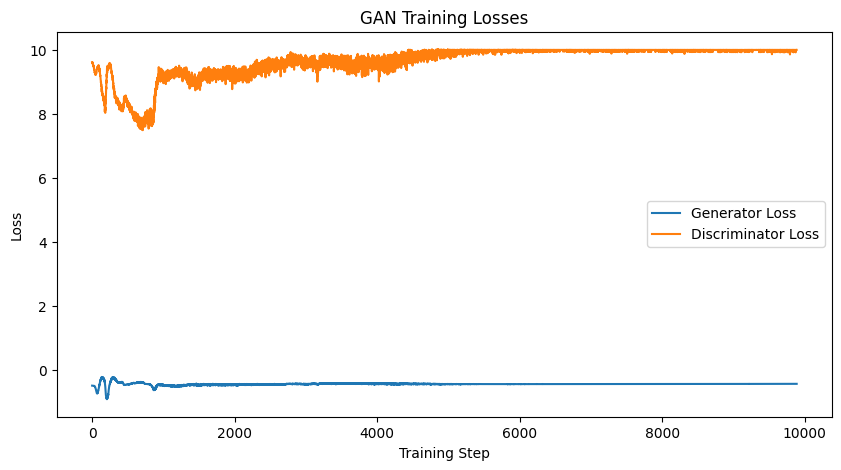

Epoch  23


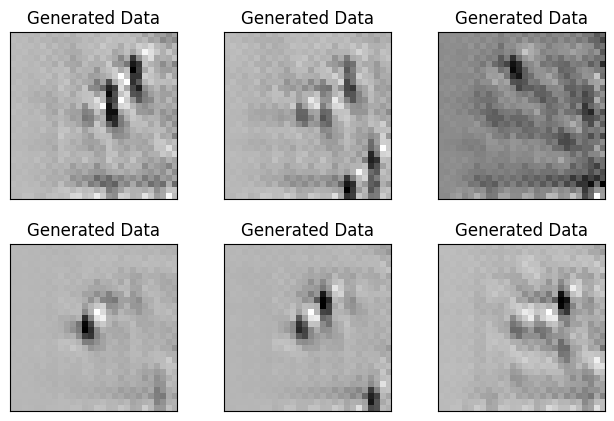

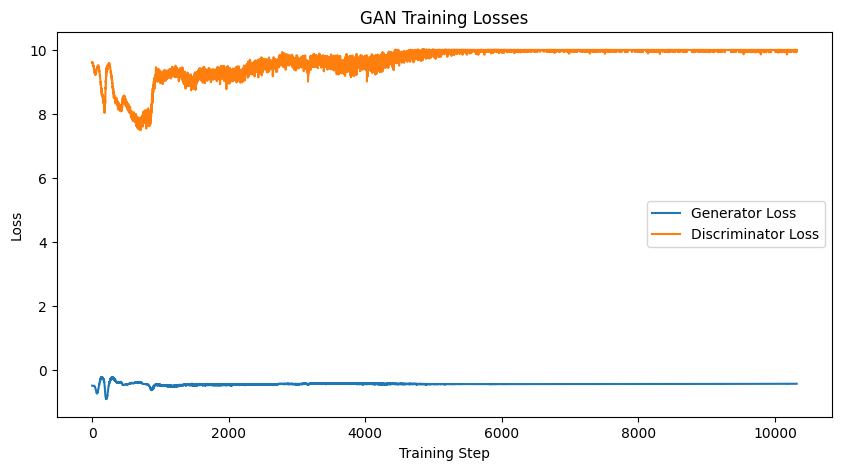

Epoch  24


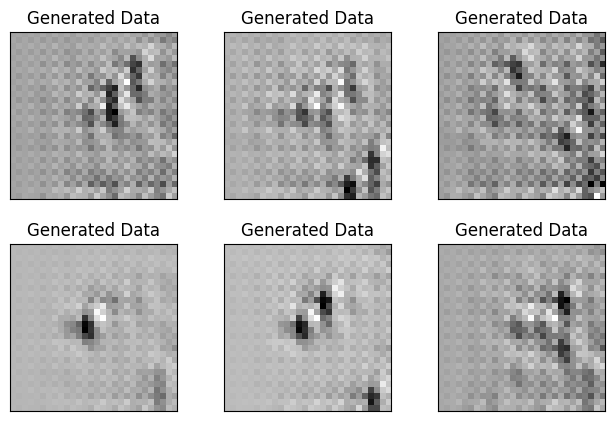

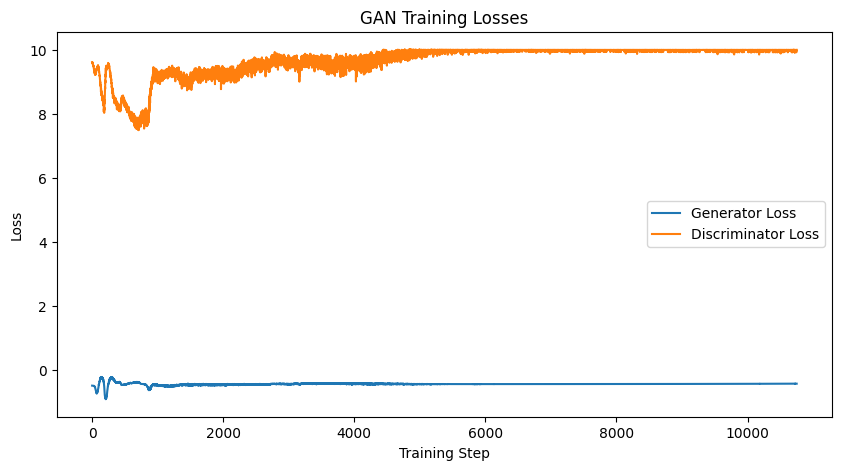

Epoch  25


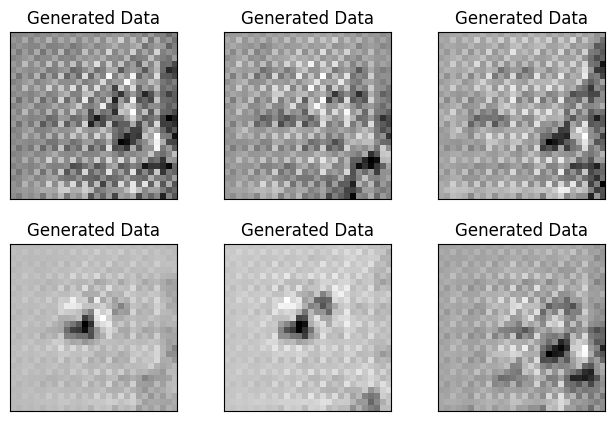

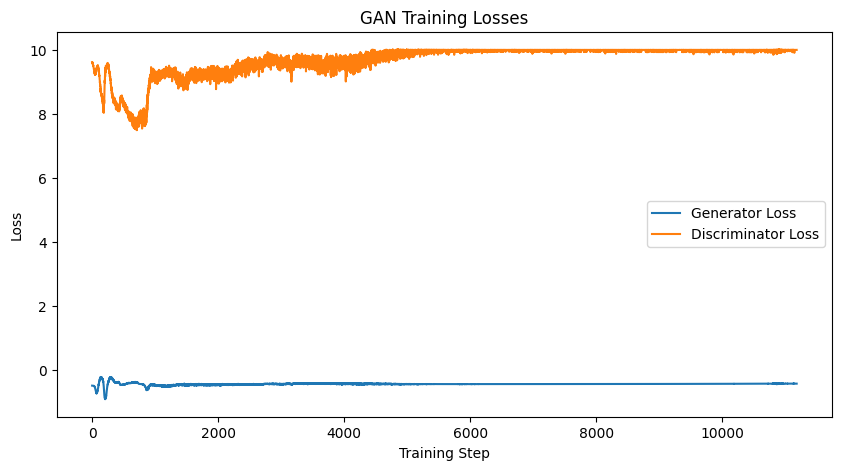

Epoch  26


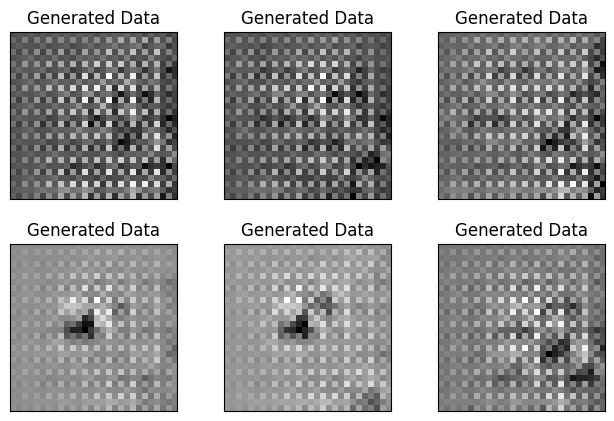

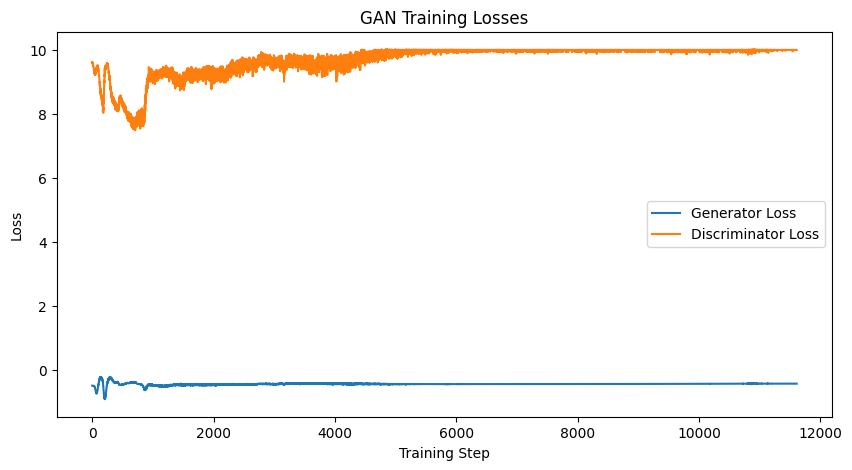

Epoch  27


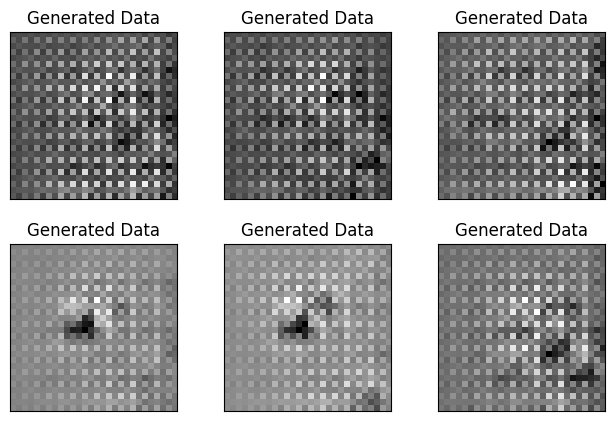

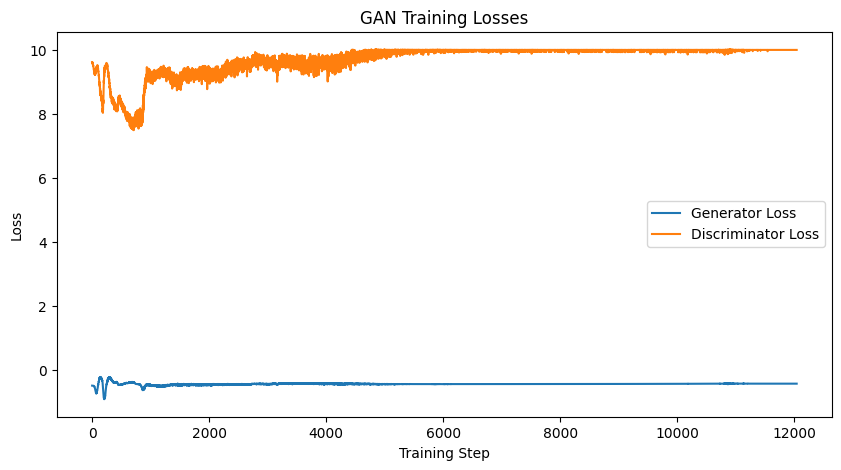

Epoch  28


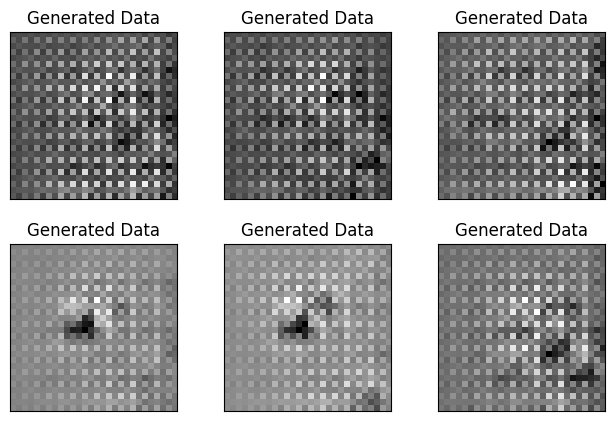

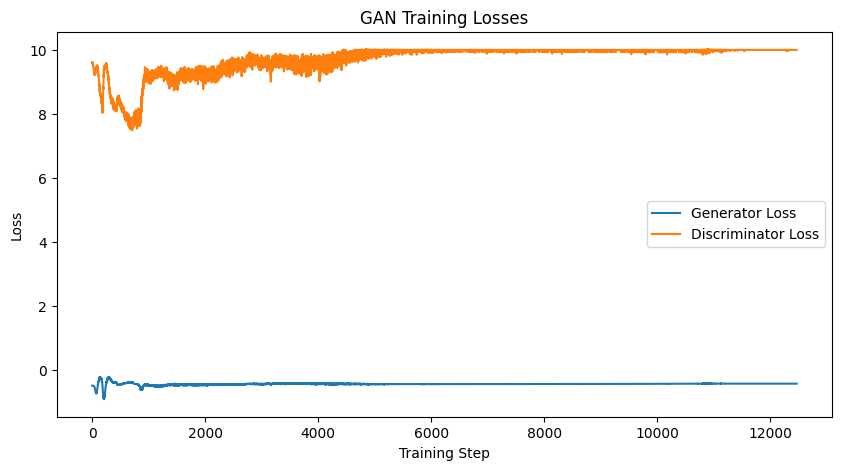

Epoch  29


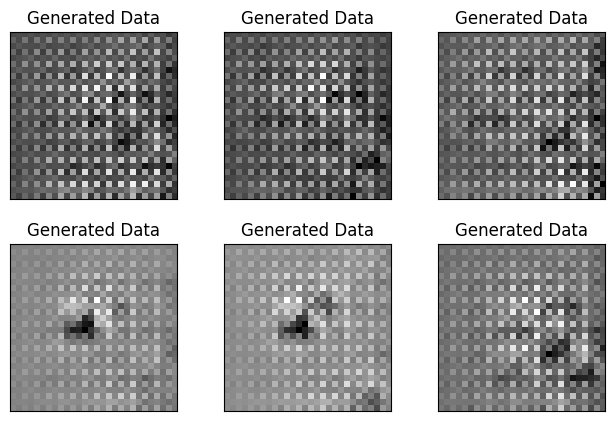

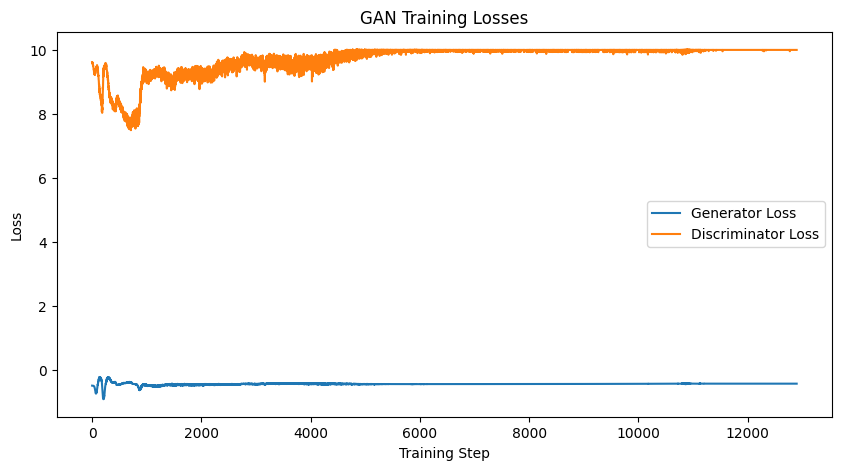

Epoch  30


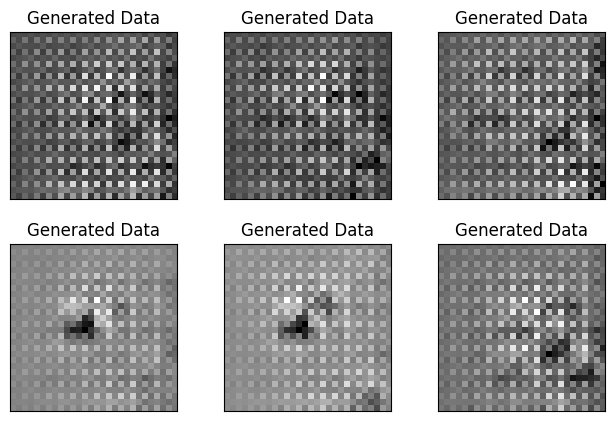

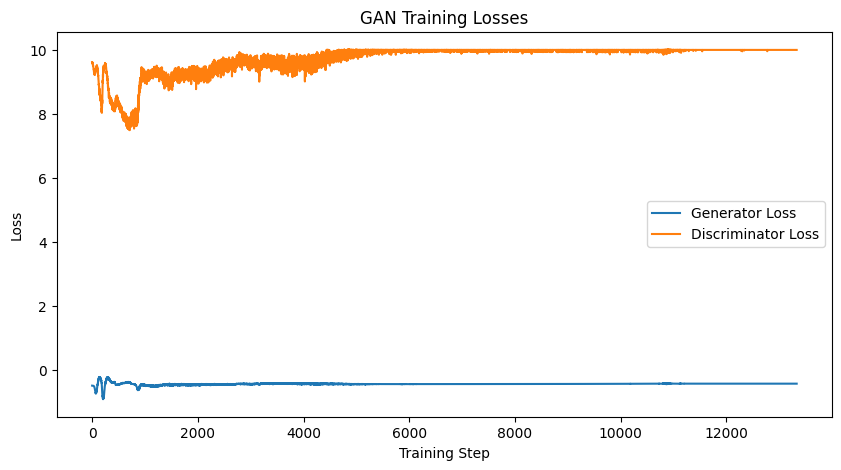

Epoch  31


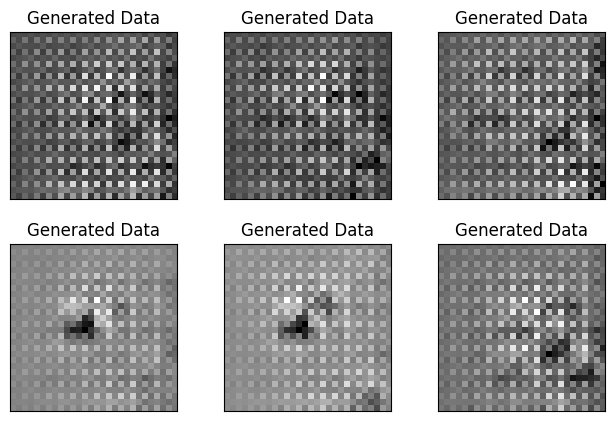

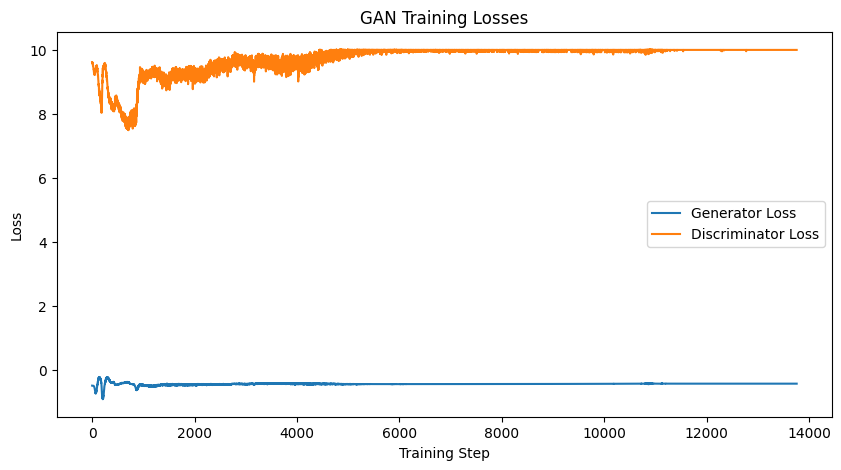

Epoch  32


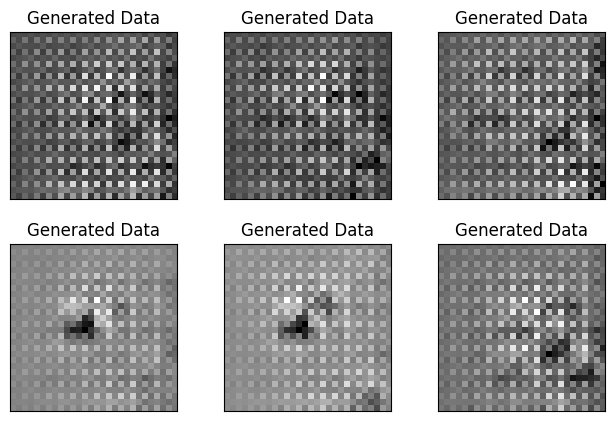

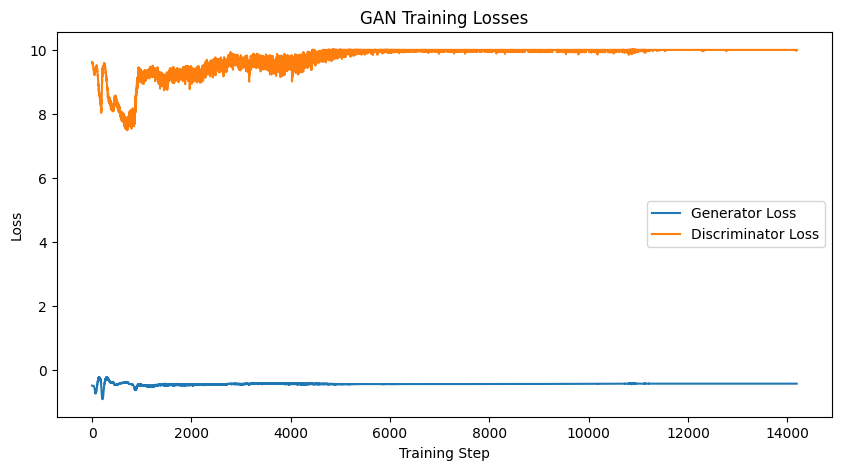

Epoch  33


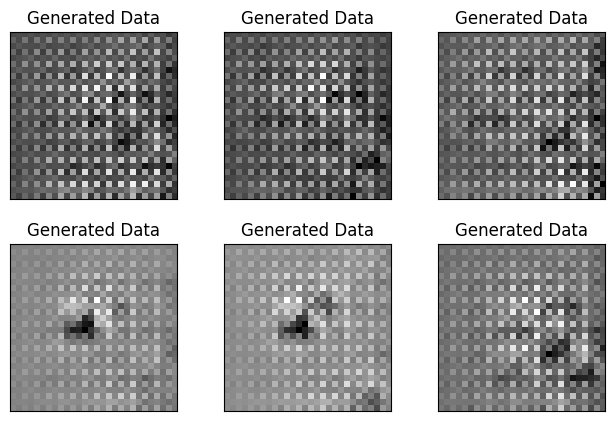

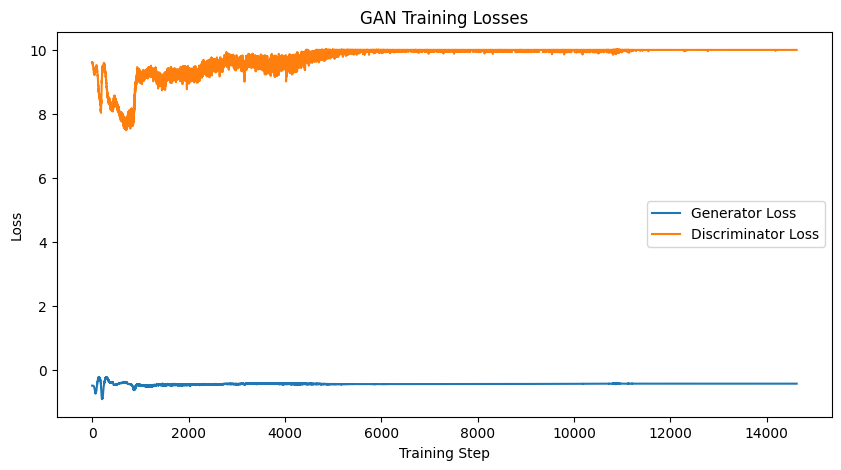

Epoch  34


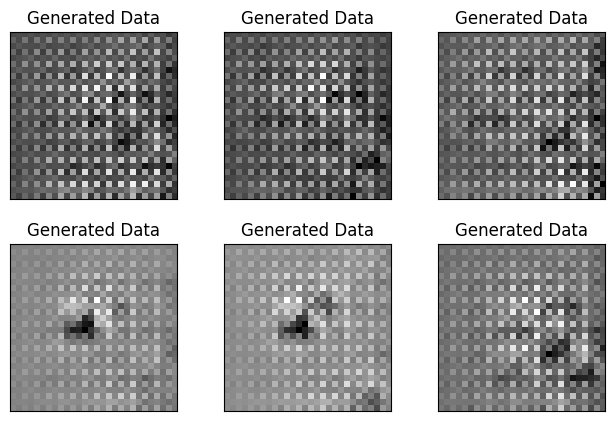

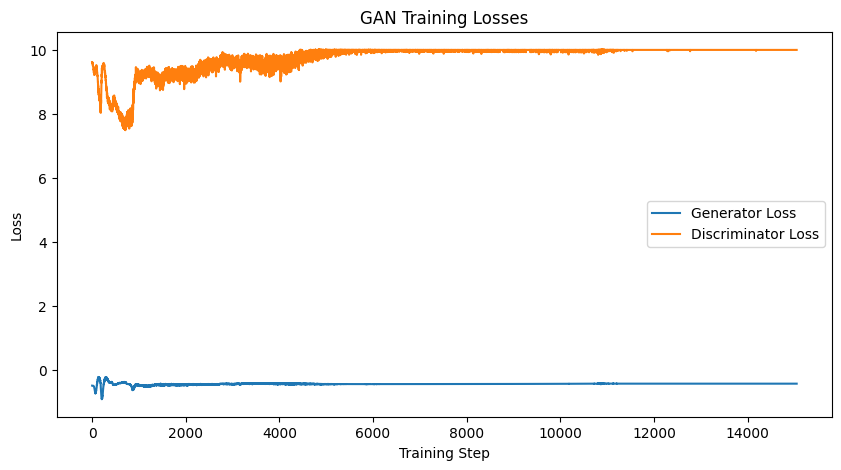

Epoch  35


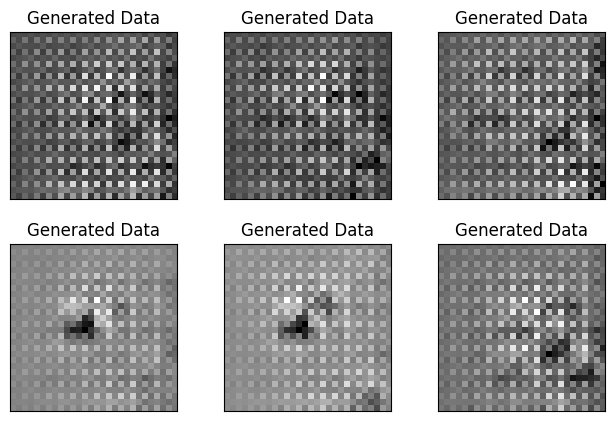

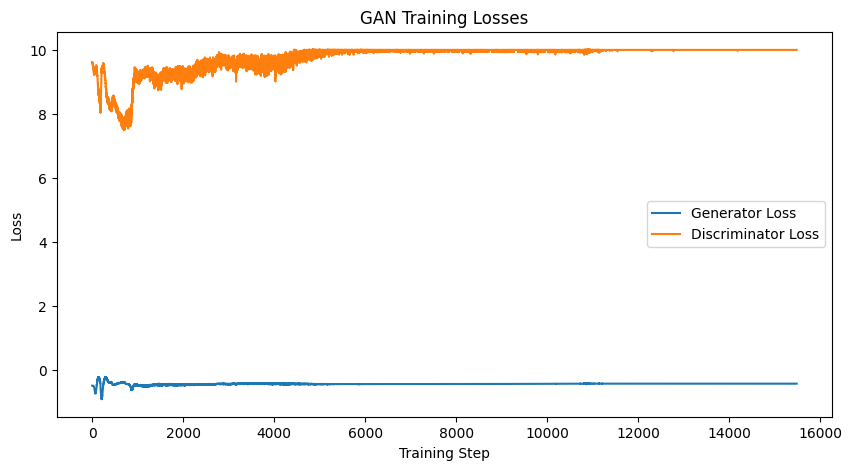

Epoch  36


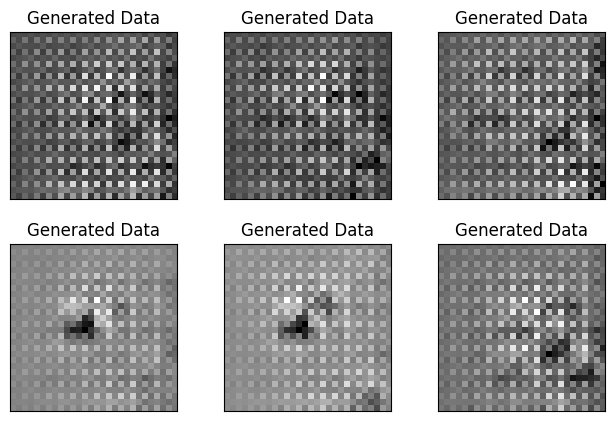

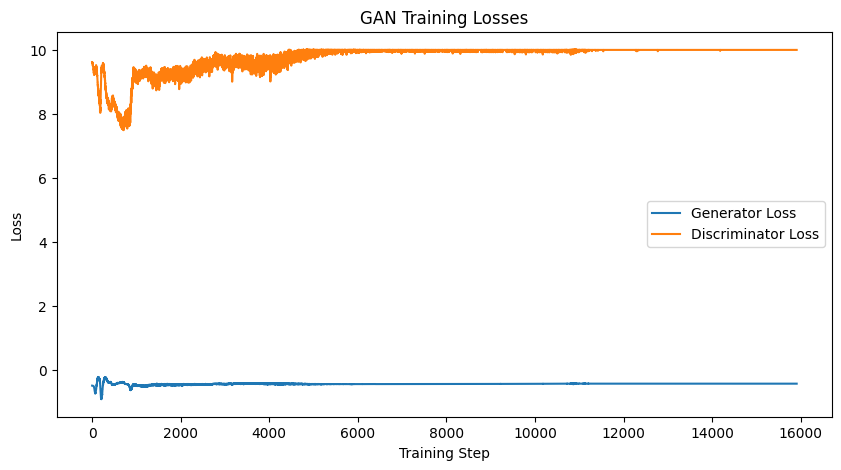

Epoch  37


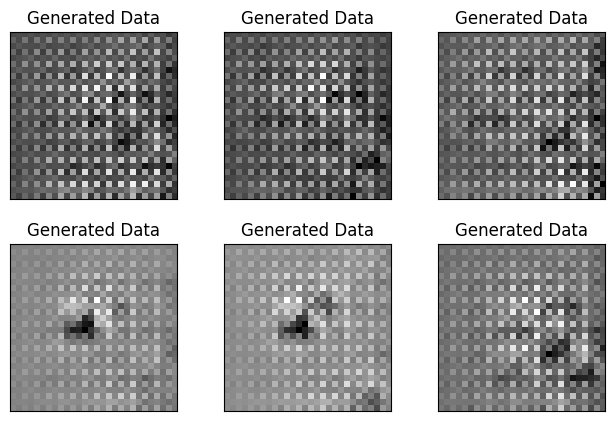

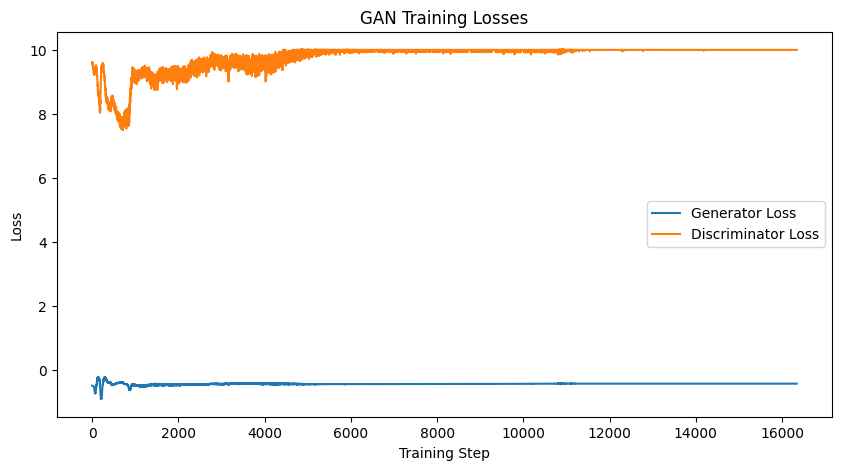

Epoch  38


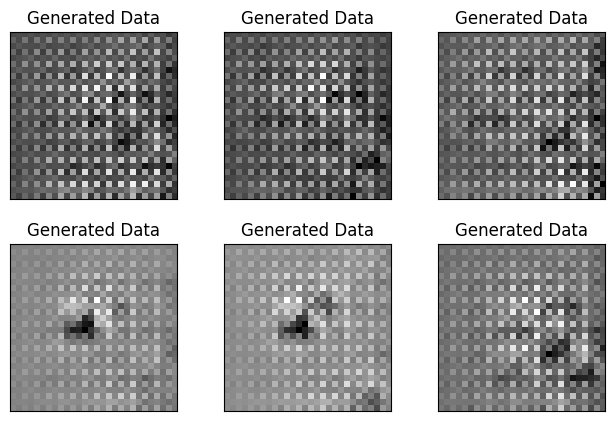

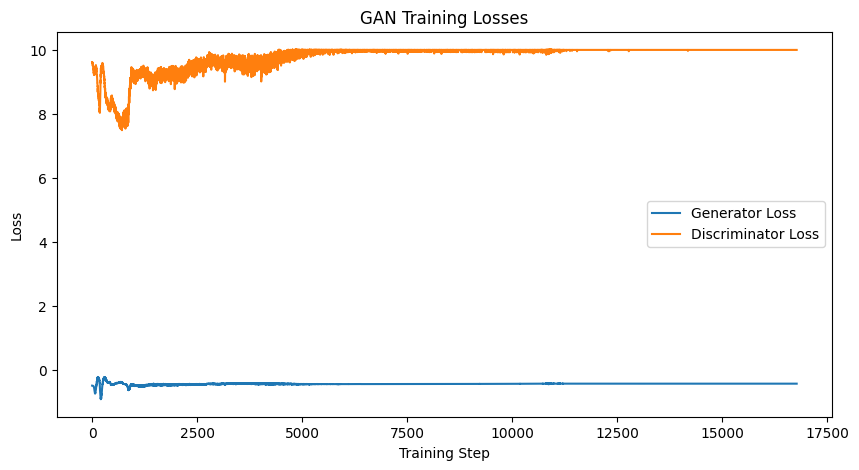

Epoch  39


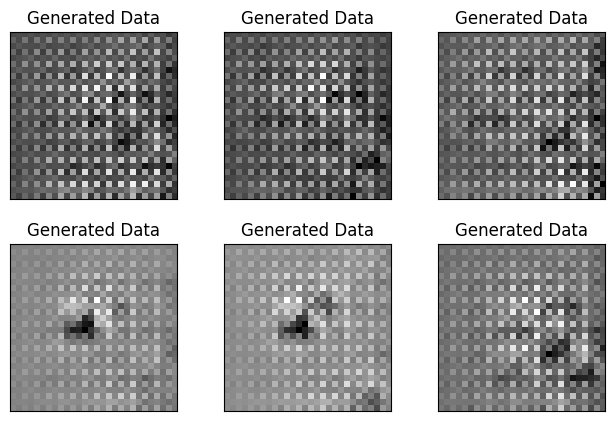

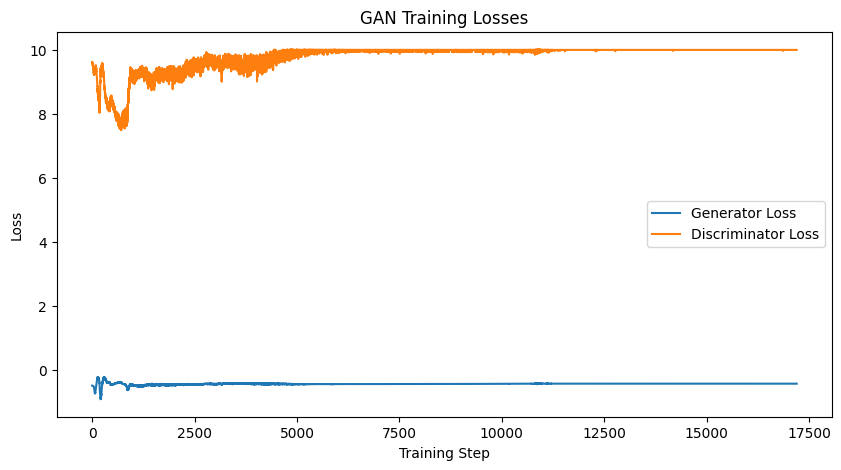

Epoch  40


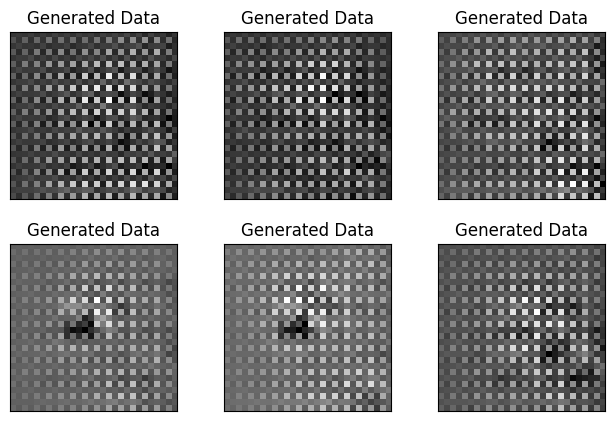

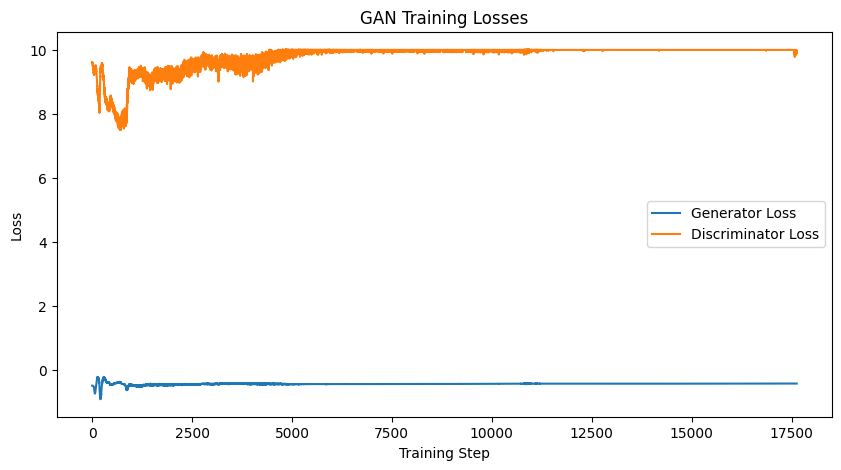

Epoch  41


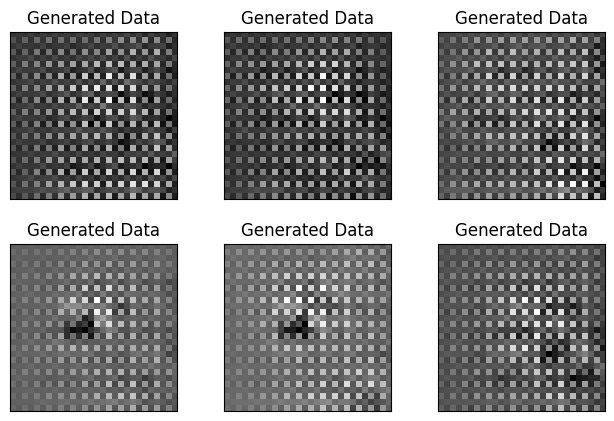

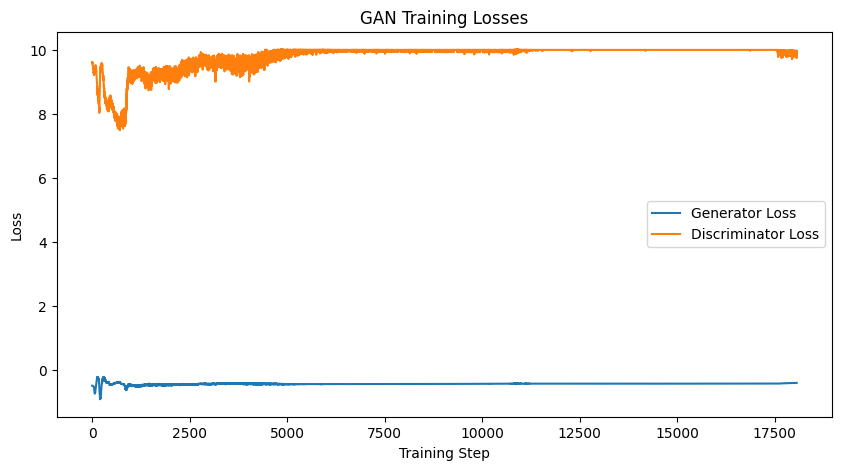

Epoch  42


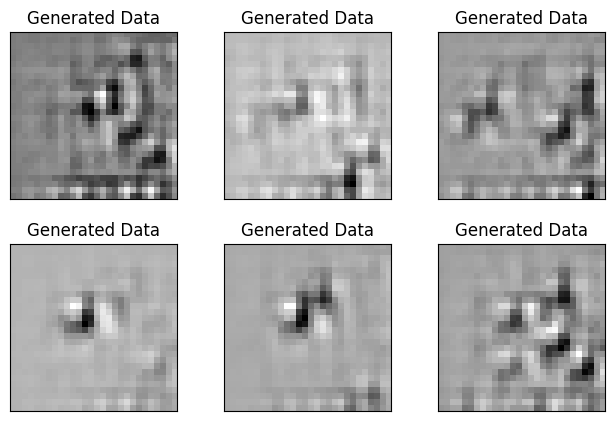

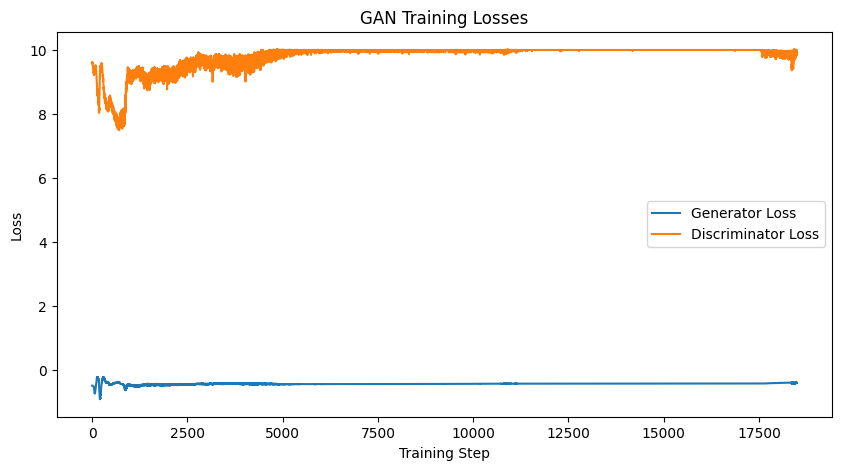

Epoch  43


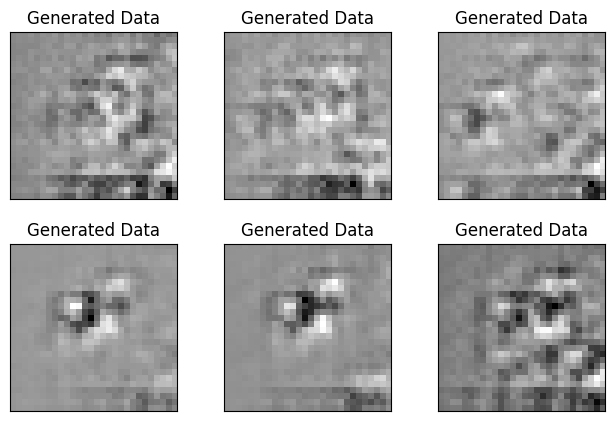

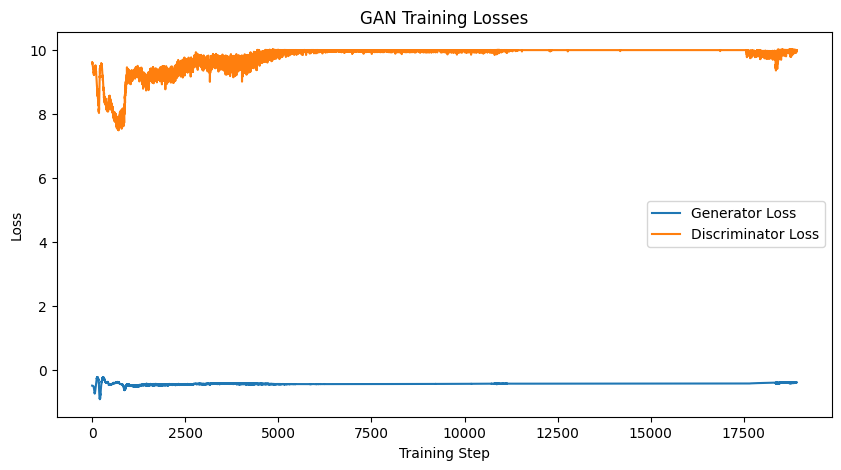

Epoch  44


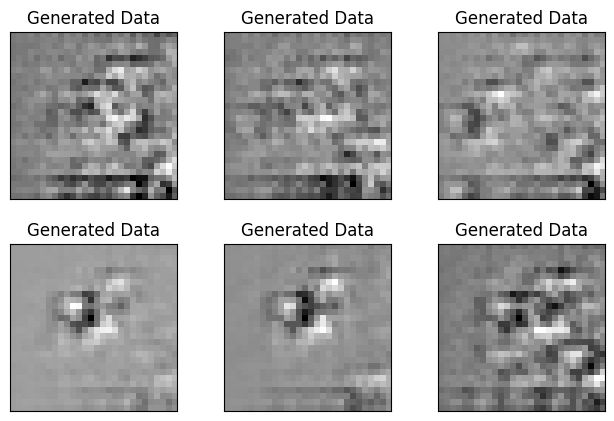

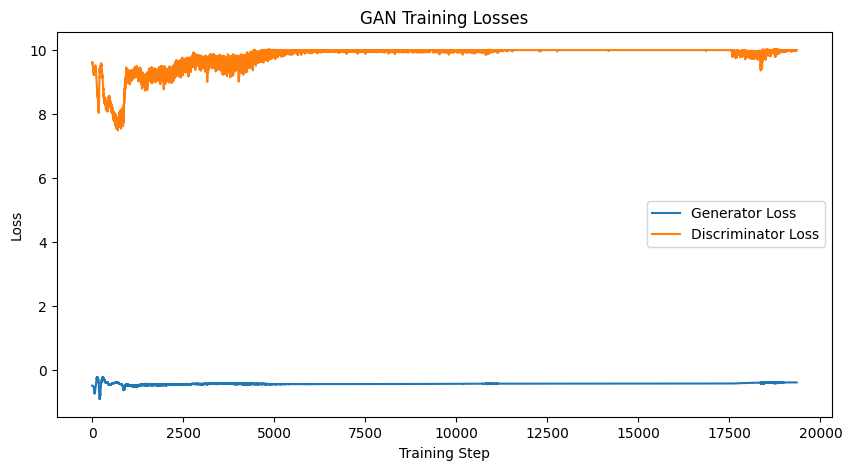

Epoch  45


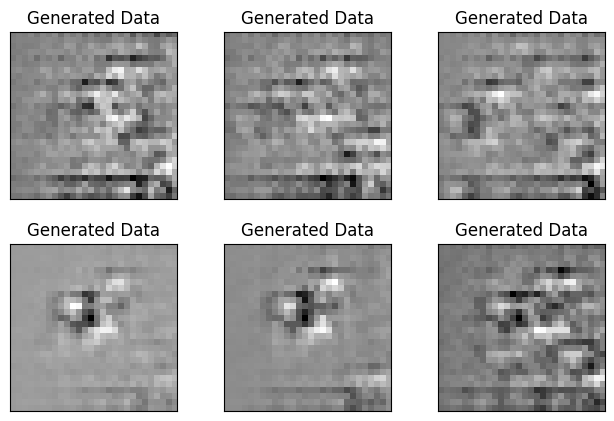

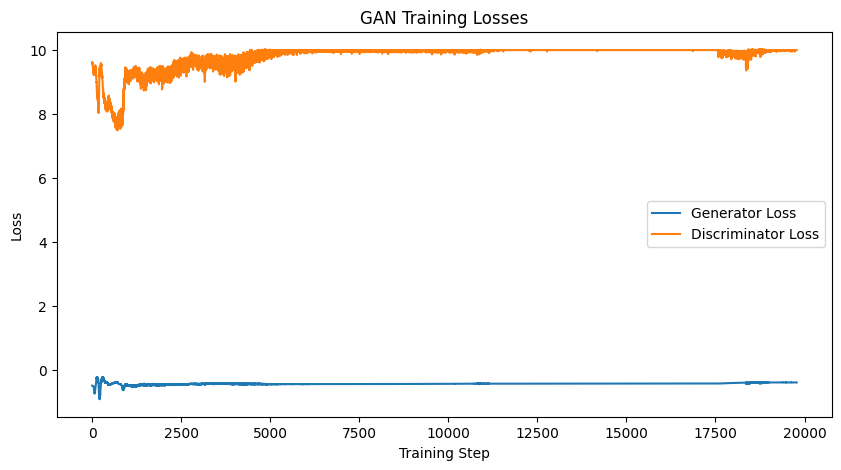

Epoch  46


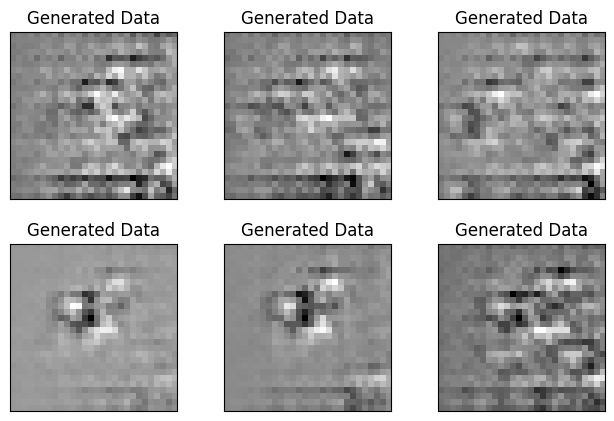

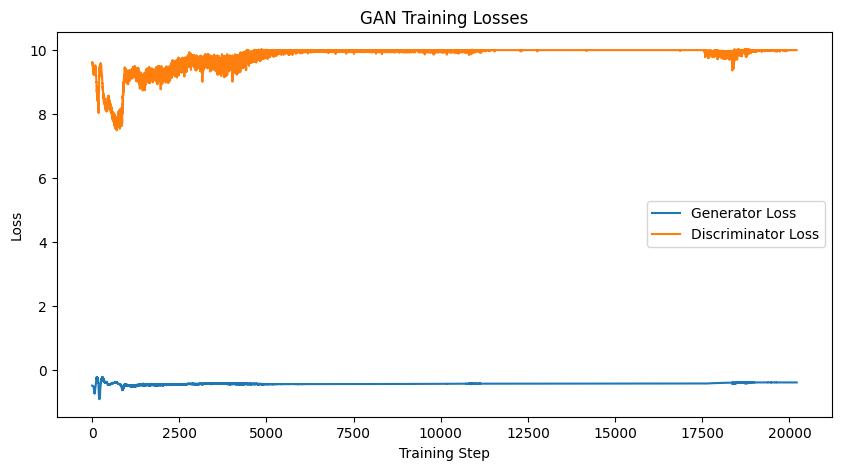

Epoch  47


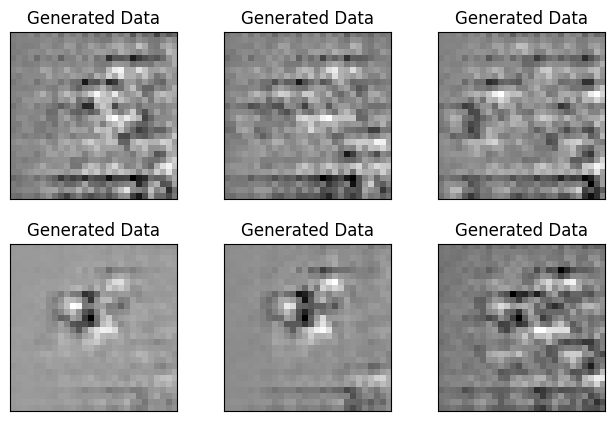

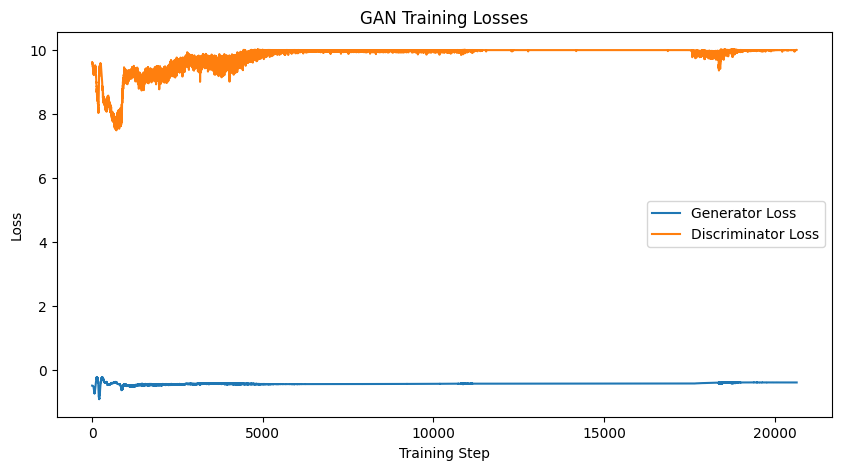

Epoch  48


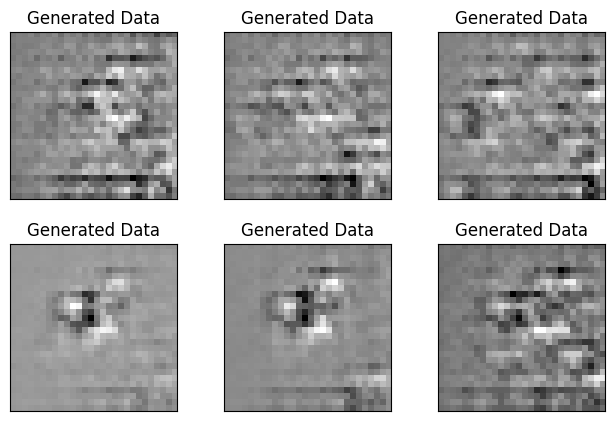

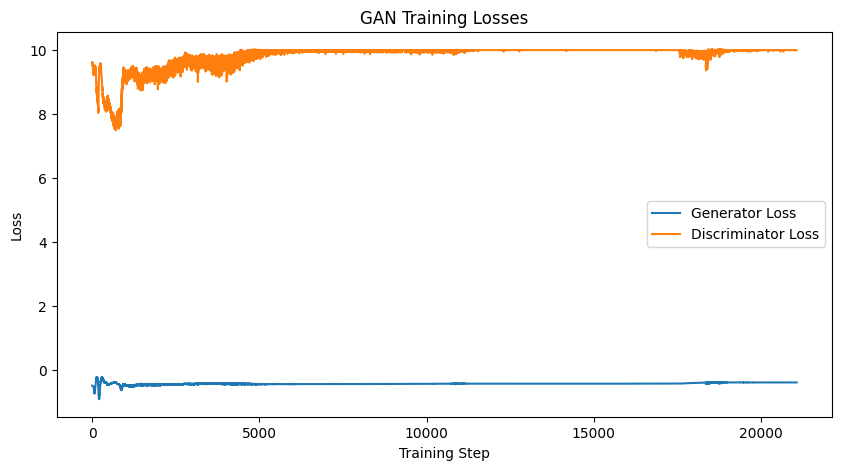

Epoch  49


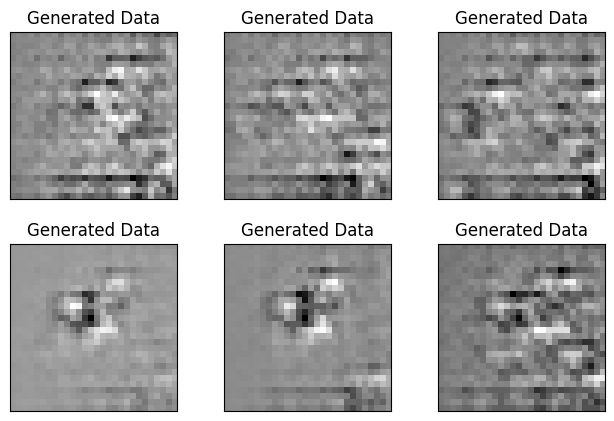

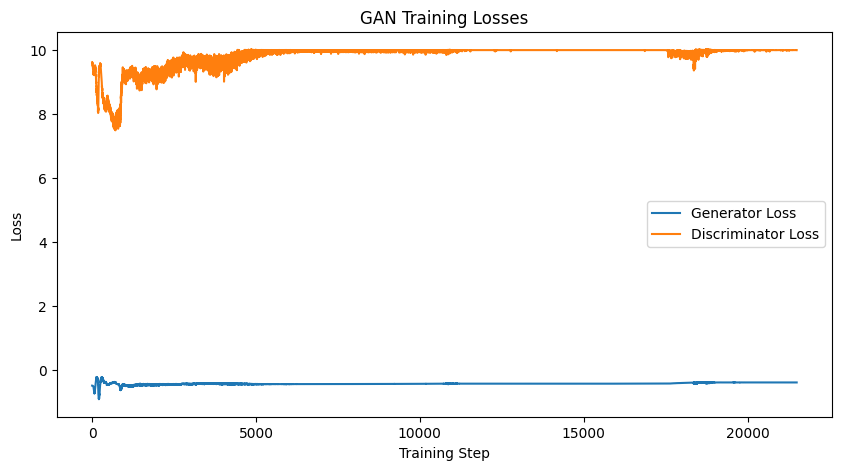

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [21]:
trainer = L.Trainer(max_epochs=50, accelerator='gpu', devices=AVAILABLE_GPUS)
trainer.fit(model, dm)

Epoch  50


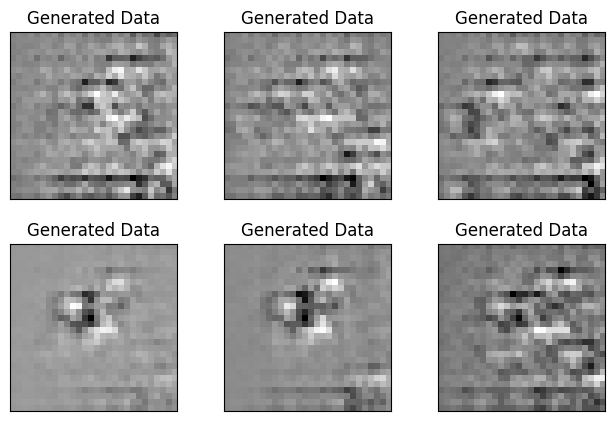

In [22]:
model.plot_images()